# Time Series & Panel Data Analysis (Academic Exercise)

This notebook explores forecasting and econometric modeling across different approaches:
- **Time series methods**: ARIMA for linear dynamics and LSTM for neural network forecasting.  
- **Panel data econometrics**: Pooled OLS, Fixed Effects, Random Effects, with diagnostic tests and robust covariance.  
- **Applied examples**: Airline dataset for estimator comparison, RNN models for store‑level weekly sales, and custom train/validation/test splits by store.  

It is archived as part of the [Neural-Network-Exercises](https://github.com/SemyonKim/Neural-Network-Exercises) repository.


##1. Imports

In [ ]:
# --- Install dependencies (if needed in Colab) ---
# %pip install statsmodels==0.12.1 pmdarima tensorflow keras linearmodels

# --- Imports ---
import warnings
from math import sqrt
import numpy as np
import numpy.dual as dual
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import read_csv, DataFrame, Series, concat
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Panel data models
from linearmodels import PooledOLS, PanelOLS, RandomEffects
from linearmodels.panel.results import compare

# Statistical tests
from scipy import stats

sns.set(style="whitegrid", palette="Set2")
warnings.filterwarnings("ignore")

## 2. Time Series Analysis
We apply ARIMA modeling and LSTM neural networks to forecast values.

###ARIMA Model
In this section, we analyze monthly alcohol sales data using ARIMA models.  
The workflow includes:
- **Data loading & visualization**: Import the dataset, inspect first rows, and plot the time series.  
- **Distribution analysis**: Histogram and kernel density plots to understand data spread.  
- **Stationarity checks**: Augmented Dickey-Fuller test on raw and differenced series.  
- **Autocorrelation diagnostics**: ACF and PACF plots to guide ARIMA parameter selection.  
- **Model fitting & validation**: Walk-forward validation with ARIMA(18,1,15), forecast evaluation, and RMSE calculation.  
- **Parameter search**: Grid search over p, d, q values to identify the best ARIMA configuration.  

This structured approach demonstrates how to prepare, diagnose, and fit ARIMA models for time series forecasting.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if __name__ == '__main__':


DATE
1992-01-01    3459
1992-02-01    3458
1992-03-01    4002
1992-04-01    4564
1992-05-01    4221
Name: S4248SM144NCEN, dtype: int64


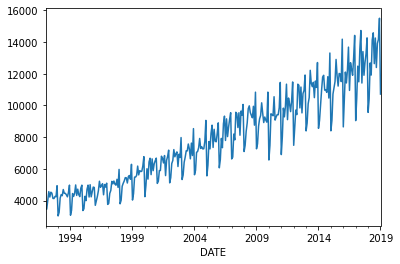

(325,)

In [ ]:
# Custom parser for dates
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

# Load dataset (monthly alcohol sales)
series = read_csv(
    "data/Alcohol_Sales.csv",
    header=0,
    parse_dates=[0],
    index_col=0,
    squeeze=True,
    date_parser=parser
)

# Preview first rows
print(series.head())

# Plot time series
series.plot(title="Alcohol Sales Over Time", figsize=(10,6))
plt.show()

print("Dataset shape:", series.shape)

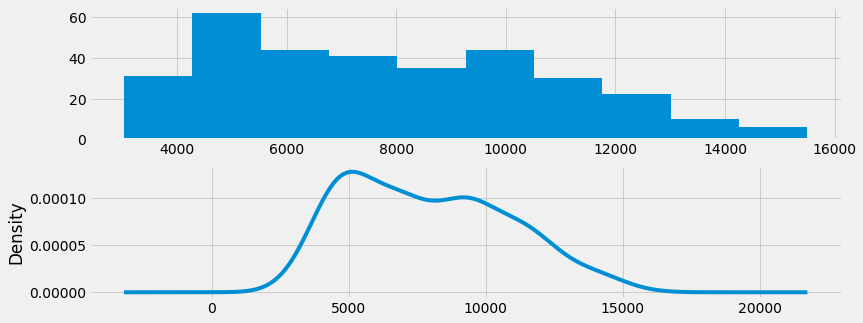

In [ ]:
# Histogram and KDE plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,5))
series.hist(ax=ax1)
series.plot(kind='kde', ax=ax2)
ax1.set_title("Histogram of Sales")
ax2.set_title("Kernel Density Estimate of Sales")
plt.tight_layout()
plt.show()

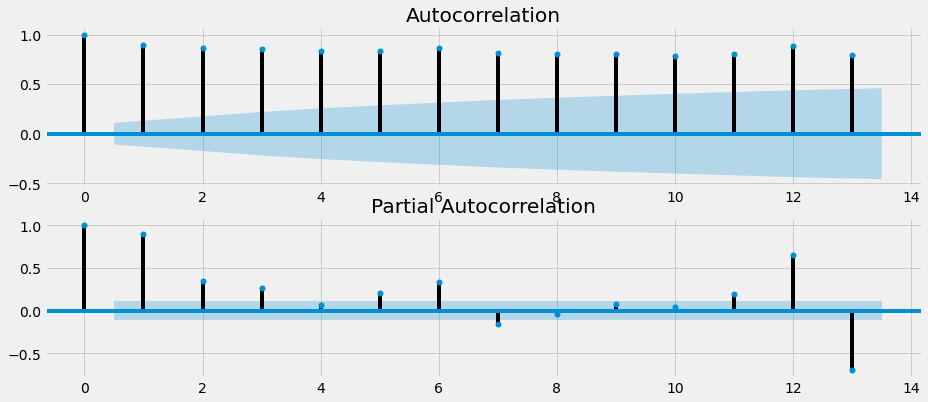

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6))
plot_acf(series, lags=13, ax=ax1)
plot_pacf(series, lags=13, ax=ax2)
ax1.set_title("Autocorrelation Function (ACF)")
ax2.set_title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()

In [ ]:
# Augmented Dickey-Fuller test
dftest = adfuller(series)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
print("ADF Test Results:\n", dfoutput)

Test Statistic                   2.037405
p-value                          0.998720
#Lags Used                      14.000000
Number of Observations Used    310.000000
Critical Value (1%)             -3.451622
Critical Value (5%)             -2.870909
Critical Value (10%)            -2.571762
dtype: float64


In [ ]:
df_diff = series.diff().dropna()

print("Results of Dickey-Fuller Test on Differenced Series:")
dftest = adfuller(df_diff)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -4.365960
p-value                          0.000341
#Lags Used                      13.000000
Number of Observations Used    310.000000
Critical Value (1%)             -3.451622
Critical Value (5%)             -2.870909
Critical Value (10%)            -2.571762
dtype: float64


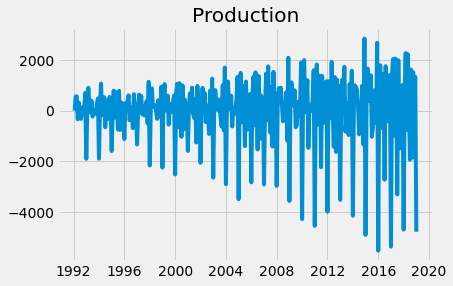

In [ ]:
# Plot differenced series
df_diff.plot(title="Differenced Alcohol Sales", figsize=(10,6))
plt.show()

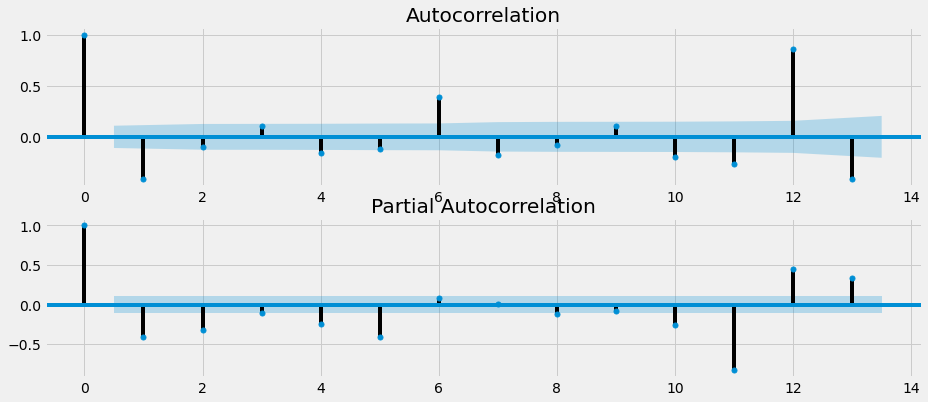

In [ ]:
# ACF/PACF on differenced series
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6))
plot_acf(df_diff, lags=13, ax=ax1)
plot_pacf(df_diff, lags=13, ax=ax2)
ax1.set_title("ACF (Differenced Series)")
ax2.set_title("PACF (Differenced Series)")
plt.tight_layout()
plt.show()

predicted=9041.432029, expected=9043.000000
predicted=11268.871180, expected=10452.000000
predicted=12018.703891, expected=12481.000000
predicted=11478.138142, expected=11491.000000
predicted=13303.932983, expected=13545.000000
predicted=13862.015331, expected=14730.000000
predicted=11317.004284, expected=11416.000000
predicted=13873.568153, expected=13402.000000
predicted=12377.360471, expected=11907.000000
predicted=12664.016070, expected=12711.000000
predicted=13399.522558, expected=13261.000000
predicted=14437.386361, expected=14265.000000
predicted=9878.081757, expected=9564.000000
predicted=10882.772434, expected=10415.000000
predicted=12511.129973, expected=12683.000000
predicted=11696.600664, expected=11919.000000
predicted=13514.948865, expected=14138.000000
predicted=14535.659706, expected=14583.000000
predicted=11869.116799, expected=12640.000000
predicted=13870.044313, expected=14257.000000
predicted=12261.797846, expected=12396.000000
predicted=13563.870769, expected=13914

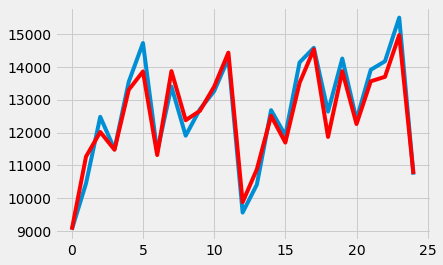

In [ ]:
# Convert index to monthly period
series.index = series.index.to_period('M')

# Split into train/test
X = series.values
size = int(len(X) * 0.926)
train, test = X[:size], X[size:]
history = list(train)
predictions = []

# Walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(18,1,15))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print(f"predicted={yhat:.2f}, expected={obs:.2f}")

# Evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print(f"Test RMSE: {rmse:.3f}")

# Plot forecasts vs actual
plt.figure(figsize=(10,6))
plt.plot(test, label="Test Data")
plt.plot(predictions, color="red", label="Predictions")
plt.title("ARIMA Walk-Forward Validation")
plt.legend()
plt.show()

In [ ]:
# Evaluate ARIMA model for given order
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.926)
    train, test = X[:train_size], X[train_size:]
    history = list(train)
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Grid search over p,d,q
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype("float32")
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print(f"ARIMA{order} RMSE={rmse:.3f}")
                except:
                    continue
    print(f"Best ARIMA{best_cfg} RMSE={best_score:.3f}")

# Run grid search
p_values = range(0,11)
d_values = range(1,3)
q_values = range(0,4)

evaluate_models(series.values, p_values, d_values, q_values)

###LSTM Model
In this section, we forecast monthly alcohol sales using a **Long Short-Term Memory (LSTM)** neural network.  
The workflow includes:
- **Data loading & visualization**: Import the dataset and inspect the time series.  
- **Stationarity transformation**: Apply differencing to remove trends.  
- **Supervised framing**: Convert time series into supervised learning format (lagged features).  
- **Scaling**: Normalize values to [-1, 1] for neural network training.  
- **Model training**: Fit a stateful LSTM model with walk-forward validation.  
- **Forecasting & evaluation**: Generate predictions, invert scaling/differencing, and compute RMSE.  


In [ ]:
# Helper Functions:
# Date parser
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

# Frame a sequence as supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# Differencing
def difference(dataset, interval=1):
    return Series([dataset[i] - dataset[i-interval] for i in range(interval, len(dataset))])

# Inverse differencing
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# Scaling
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# Invert scaling
def invert_scale(scaler, X, value):
    new_row = list(X) + [value]
    array = np.array(new_row).reshape(1, len(new_row))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# Fit LSTM model
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# Forecast one step
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

DATE
1992-01-01    3459
1992-02-01    3458
1992-03-01    4002
1992-04-01    4564
1992-05-01    4221
Name: S4248SM144NCEN, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  if __name__ == '__main__':


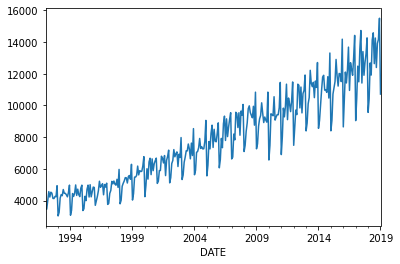

(325,)

In [ ]:
# Load and Visualize Dataset:
series = read_csv("data/Alcohol_Sales.csv", header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

print("First rows:\n", series.head())
series.plot(title="Alcohol Sales Over Time", figsize=(10,6))
plt.show()
print("Dataset shape:", series.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  app.launch_new_instance()


data loaded
stationary
supervisedlearning
split data
scaler
fit model
predict
Month=1, Predicted=10452.000000, Expected=10452.000000
Month=2, Predicted=12481.000000, Expected=12481.000000
Month=3, Predicted=11491.000000, Expected=11491.000000
Month=4, Predicted=13545.000000, Expected=13545.000000
Month=5, Predicted=14730.000000, Expected=14730.000000
Month=6, Predicted=11416.000000, Expected=11416.000000
Month=7, Predicted=13402.000000, Expected=13402.000000
Month=8, Predicted=11907.000000, Expected=11907.000000
Month=9, Predicted=12711.000000, Expected=12711.000000
Month=10, Predicted=13261.000000, Expected=13261.000000
Month=11, Predicted=14265.000000, Expected=14265.000000
Month=12, Predicted=9564.000000, Expected=9564.000000
Month=13, Predicted=10415.000000, Expected=10415.000000
Month=14, Predicted=12683.000000, Expected=12683.000000
Month=15, Predicted=11919.000000, Expected=11919.000000
Month=16, Predicted=14138.000000, Expected=14138.000000
Month=17, Predicted=14583.000000, Exp

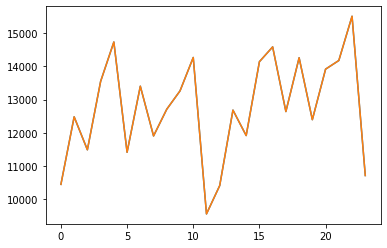

In [ ]:
# Transformations:
# Raw values
raw_values = series.values

# Differencing for stationarity
diff_values = difference(raw_values, 1)
print("Stationarity transformation complete.")

# Supervised framing
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
print("Supervised learning framing complete.")

# Train/test split
train, test = supervised_values[:-24], supervised_values[-24:]
print("Train/test split complete.")

# Scaling
scaler, train_scaled, test_scaled = scale(train, test)
print("Scaling complete.")

# Model Training:
# Fit LSTM model
lstm_model = fit_lstm(train_scaled, batch_size=1, nb_epoch=3000, neurons=4)
print("Model training complete.")

# Forecast training set to build state
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
print("Training state built.")

# Walk‑Forward Validation:
predictions = []
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    # Forecast (currently using y directly; can replace with forecast_lstm)
    yhat = y
    # Invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # Invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print(f"Month={i+1}, Predicted={yhat:.2f}, Expected={expected:.2f}")

# Evaluation:
rmse = sqrt(mean_squared_error(raw_values[-24:], predictions))
print(f"Test RMSE: {rmse:.3f}")

# Plot observed vs predicted
plt.figure(figsize=(10,6))
plt.plot(raw_values[-24:], label="Observed")
plt.plot(predictions, label="Predicted", color="red")
plt.title("LSTM Forecast vs Observed")
plt.legend()
plt.show()

## 3. Panel Data Analysis

This block demonstrates econometric and neural network approaches to panel data, including OLS/FE/RE models, RNN forecasting, and store‑level train/validation/test splits.



###Pooled OLS, Fixed Effects, Random Effects

In this section, we analyze weekly sales data across stores using panel data econometric models.  
The workflow includes:
- **Data preparation**: Merge sales, features, and store datasets; clean variables.  
- **Transformations**: Log transformations for scale normalization.  
- **Model estimation**: Pooled OLS, Fixed Effects, Random Effects.  
- **Diagnostics**: F‑tests, LM test, Hausman test.  
- **Robust covariance**: Clustered standard errors.  
- **Model comparison**: Compare pooled, fixed, and random effects estimators.  

#### Load and Prepare Data
We merge sales, features, and store datasets, format dates, and encode categorical variables.


In [ ]:
df_stores = pd.read_csv("data/stores.csv")
df_features = pd.read_csv("data/features.csv")
df_sales = pd.read_csv("data/sales.csv")

# Format dates
df_features['Date'] = pd.to_datetime(df_features['Date'], format="%d/%m/%Y")
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format="%d/%m/%Y")

# Aggregate weekly sales by store/date
store_sales = df_sales.groupby(['Store','Date'])['Weekly_Sales'].sum().reset_index()

# Merge with features
data = pd.merge(store_sales, df_features, how='left', on=['Store','Date'])
data.sort_values("Date", inplace=True)

# Drop markdown variables
data.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], inplace=True)

# Encode holiday flag
data['IsHolidayNumeric'] = data['IsHoliday'].apply(lambda x: 1 if str(x)=="True" else 0)

data.head()

Store       Date  Weekly_Sales  ...  Unemployment  IsHoliday  IsHolidayNumeric
0         1 2010-02-05    1643690.90  ...         8.106      False                 0
1         1 2010-02-12    1641957.44  ...         8.106       True                 1
2         1 2010-02-19    1611968.17  ...         8.106      False                 0
3         1 2010-02-26    1409727.59  ...         8.106      False                 0
4         1 2010-03-05    1554806.68  ...         8.106      False                 0
...     ...        ...           ...  ...           ...        ...               ...
6430     45 2012-09-28     713173.95  ...         8.684      False                 0
6431     45 2012-10-05     733455.07  ...         8.667      False                 0
6432     45 2012-10-12     734464.36  ...         8.667      False                 0
6433     45 2012-10-19     718125.53  ...         8.667      False                 0
6434     45 2012-10-26     760281.43  ...         8.667      False                 0

[6435 rows x 9 columns]

In [ ]:
# Inspect Data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3432 entries, 0 to 3431
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Store             3432 non-null   int64         
 1   Date              3432 non-null   datetime64[ns]
 2   Weekly_Sales      3432 non-null   float64       
 3   Temperature       3432 non-null   float64       
 4   Fuel_Price        3432 non-null   float64       
 5   CPI               3432 non-null   float64       
 6   Unemployment      3432 non-null   float64       
 7   IsHoliday         3432 non-null   bool          
 8   IsHolidayNumeric  3432 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(2)
memory usage: 244.7 KB


In [ ]:
# Set panel index
data = data.set_index(['Store', 'Date'])
data

Weekly_Sales  Temperature  ...  IsHoliday  IsHolidayNumeric
Store Date                                   ...                             
1     2010-02-05    1643690.90        42.31  ...      False                 0
      2010-02-12    1641957.44        38.51  ...       True                 1
      2010-02-19    1611968.17        39.93  ...      False                 0
      2010-02-26    1409727.59        46.63  ...      False                 0
      2010-03-05    1554806.68        46.50  ...      False                 0
...                        ...          ...  ...        ...               ...
45    2012-09-28     713173.95        64.88  ...      False                 0
      2012-10-05     733455.07        64.89  ...      False                 0
      2012-10-12     734464.36        54.47  ...      False                 0
      2012-10-19     718125.53        56.47  ...      False                 0
      2012-10-26     760281.43        58.85  ...      False                 0

[6435 rows x 7 columns]

In [ ]:
data.describe()

Weekly_Sales  Temperature  ...  Unemployment  IsHolidayNumeric
count  6.435000e+03  6435.000000  ...   6435.000000       6435.000000
mean   1.046965e+06    60.663782  ...      7.999151          0.069930
std    5.643666e+05    18.444933  ...      1.875885          0.255049
min    2.099863e+05    -2.060000  ...      3.879000          0.000000
25%    5.533501e+05    47.460000  ...      6.891000          0.000000
50%    9.607460e+05    62.670000  ...      7.874000          0.000000
75%    1.420159e+06    74.940000  ...      8.622000          0.000000
max    3.818686e+06   100.140000  ...     14.313000          1.000000

[8 rows x 6 columns]

#### Transform Variables
We log-transform selected variables to stabilize variance and normalize scale.

In [ ]:
Sales = np.log(data.Weekly_Sales)
Temperatures = data.Temperature
Fuel_Prices = np.log(data.Fuel_Price)
CPIs = np.log(data.CPI)
Unemployments = data.Unemployment
IsHolidays = data.IsHolidayNumeric

df = pd.DataFrame({
    "Sales": Sales,
    "Temperatures": Temperatures,
    "Fuel_Prices": Fuel_Prices,
    "CPIs": CPIs,
    "Unemployments": Unemployments,
    "IsHolidays": IsHolidays
})

print(df.head())
df.describe()

                      Sales  Temperatures  ...  Unemployments  IsHolidays
Store Date                                 ...                           
1     2010-02-05  14.312455         42.31  ...          8.106           0
      2010-02-12  14.311400         38.51  ...          8.106           1
      2010-02-19  14.292966         39.93  ...          8.106           0
      2010-02-26  14.158907         46.63  ...          8.106           0
      2010-03-05  14.256862         46.50  ...          8.106           0
...                     ...           ...  ...            ...         ...
45    2012-09-28  13.477481         64.88  ...          8.684           0
      2012-10-05  13.505522         64.89  ...          8.667           0
      2012-10-12  13.506897         54.47  ...          8.667           0
      2012-10-19  13.484400         56.47  ...          8.667           0
      2012-10-26  13.541444         58.85  ...          8.667           0

[6435 rows x 6 columns]


Sales  Temperatures  ...  Unemployments   IsHolidays
count  6435.000000   6435.000000  ...    6435.000000  6435.000000
mean     13.701908     60.663782  ...       7.999151     0.069930
std       0.588302     18.444933  ...       1.875885     0.255049
min      12.254797     -2.060000  ...       3.879000     0.000000
25%      13.223746     47.460000  ...       6.891000     0.000000
50%      13.775465     62.670000  ...       7.874000     0.000000
75%      14.166279     74.940000  ...       8.622000     0.000000
max      15.155417    100.140000  ...      14.313000     1.000000

[8 rows x 6 columns]

####Pooled OLS

In [ ]:
# Pooled OLS
pooled = PooledOLS.from_formula(
    "Sales ~ 1 + Temperatures + Fuel_Prices + CPIs + Unemployments + IsHolidays",
    df
).fit()
print(pooled)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  Sales   R-squared:                        0.0213
Estimator:                  PooledOLS   R-squared (Between):              0.0236
No. Observations:                6435   R-squared (Within):              -0.0308
Date:                Sat, Dec 26 2020   R-squared (Overall):              0.0213
Time:                        01:37:16   Log-likelihood                   -5647.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      27.959
Entities:                          45   P-value                           0.0000
Avg Obs:                       143.00   Distribution:                  F(5,6429)
Min Obs:                       143.00                                           
Max Obs:                       143.00   F-statistic (robust):             27.959
                            

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


####Fixed Effects

In [ ]:
# Fixed Effects
fixed = PanelOLS.from_formula(
    "Sales ~ Temperatures + Fuel_Prices + CPIs + Unemployments + IsHolidays + EntityEffects",
    df
).fit()
print(fixed)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  Sales   R-squared:                        0.0282
Estimator:                   PanelOLS   R-squared (Between):              0.2844
No. Observations:                6435   R-squared (Within):               0.0282
Date:                Sat, Dec 26 2020   R-squared (Overall):              0.2844
Time:                        01:37:21   Log-likelihood                    4507.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      37.067
Entities:                          45   P-value                           0.0000
Avg Obs:                       143.00   Distribution:                  F(5,6385)
Min Obs:                       143.00                                           
Max Obs:                       143.00   F-statistic (robust):             37.067
                            

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


In [ ]:
# Extract fixed effects
fixed_effects = fixed.estimated_effects.unstack(level=0).values[0]
print(fixed_effects)


[12.00844453 12.22146291 10.64191892 12.51491115 10.39581699 11.99093587
 11.0520656  11.43426797 10.9214198  12.46911635 11.85638419 11.92109756
 12.48763608 12.35347246 11.3150353  10.92852113 11.66967698 11.88272229
 12.16288501 12.32264537 11.28192876 11.80519382 12.05739611 12.10878561
 11.22576692 11.79050607 12.35610664 12.19162571 11.20051558 10.74686914
 11.90246341 11.78319163 10.48979636 11.81141378 11.69331716 10.58090745
 10.92250445 10.96137981 11.94189147 11.69786326 11.83366057 11.24687713
 11.17117398 10.59684394 11.40984239]


In [ ]:
# F-test for fixed effects vs pooled OLS
print(fixed.f_pooled)

Pooled F-statistic
H0: Effects are zero
Statistic: 3261.6490
P-value: 0.0000
Distributed: F(44,6385)


In [ ]:
# Fixed effects with constant term
fixed1 = PanelOLS.from_formula(
    "Sales ~ 1 + Temperatures + Fuel_Prices + CPIs + Unemployments + IsHolidays + EntityEffects",
    df
).fit()
print(fixed1)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  Sales   R-squared:                        0.0282
Estimator:                   PanelOLS   R-squared (Between):             -0.0649
No. Observations:                6435   R-squared (Within):               0.0282
Date:                Sat, Dec 26 2020   R-squared (Overall):             -0.0609
Time:                        01:37:40   Log-likelihood                    4507.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      37.067
Entities:                          45   P-value                           0.0000
Avg Obs:                       143.00   Distribution:                  F(5,6385)
Min Obs:                       143.00                                           
Max Obs:                       143.00   F-statistic (robust):             37.067
                            

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


In [ ]:
# Extract fixed effects with intercept
fixed1_effects = fixed1.params.Intercept + fixed1.estimated_effects.unstack(level=0).values[0]
print(fixed1_effects)
print(fixed1.f_pooled)

[12.00844453 12.22146291 10.64191892 12.51491115 10.39581699 11.99093587
 11.0520656  11.43426797 10.9214198  12.46911635 11.85638419 11.92109756
 12.48763608 12.35347246 11.3150353  10.92852113 11.66967698 11.88272229
 12.16288501 12.32264537 11.28192876 11.80519382 12.05739611 12.10878561
 11.22576692 11.79050607 12.35610664 12.19162571 11.20051558 10.74686914
 11.90246341 11.78319163 10.48979636 11.81141378 11.69331716 10.58090745
 10.92250445 10.96137981 11.94189147 11.69786326 11.83366057 11.24687713
 11.17117398 10.59684394 11.40984239]
Pooled F-statistic
H0: Effects are zero
Statistic: 3261.6490
P-value: 0.0000
Distributed: F(44,6385)


####Random Effects

In [ ]:
random = RandomEffects.from_formula(
    "Sales ~ 1 + Temperatures + Fuel_Prices + CPIs + Unemployments + IsHolidays",
    df
).fit()
print(random)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  Sales   R-squared:                        0.0277
Estimator:              RandomEffects   R-squared (Between):             -0.0415
No. Observations:                6435   R-squared (Within):               0.0281
Date:                Sat, Dec 26 2020   R-squared (Overall):             -0.0385
Time:                        01:37:53   Log-likelihood                    4485.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      36.654
Entities:                          45   P-value                           0.0000
Avg Obs:                       143.00   Distribution:                  F(5,6429)
Min Obs:                       143.00                                           
Max Obs:                       143.00   F-statistic (robust):             36.654
                            

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


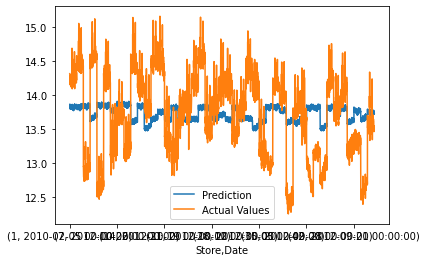

In [ ]:
# Predictions vs actual
pred_df = random.predict(fitted=True, effects=True, idiosyncratic=True)
comp = pd.DataFrame({
    "Prediction": pred_df.fitted_values,
    "Actual Values": df.Sales
})
comp.plot(title="Random Effects Predictions vs Actual")
plt.show()

In [ ]:
# Extract random effects
random_effects = random.params.Intercept + random.estimated_effects.unstack(level=0).values[0]
print(random_effects)
print(random.variance_decomposition)

[12.59568354 12.80500094 11.25308762 13.03537359 11.00868942 12.57815233
 11.64424726 12.03110004 11.52687879 12.99200522 12.44738232 12.45821462
 13.00946995 12.91939584 11.86197054 11.5204528  12.20459229 12.4215149
 12.69573832 12.90026327 11.88107293 12.34755704 12.58885429 12.64303336
 11.8215995  12.32976001 12.88888604 12.72424939 11.75170165 11.35490048
 12.4913007  12.36324567 11.04575306 12.34790487 12.23839021 11.19155425
 11.52742452 11.51443747 12.52987915 12.23529176 12.41110496 11.79006699
 11.7706075  11.14979168 11.99143915]
Effects                   0.368440
Residual                  0.014539
Percent due to Effects    0.962036
Name: Variance Decomposition, dtype: float64


####Model Comparison

In [ ]:
res = {"Pooled": pooled, "Fixed+1": fixed1, "Fixed": fixed, "Random": random}
print(compare(res))

                                   Model Comparison                                   
                                Pooled        Fixed+1          Fixed            Random
--------------------------------------------------------------------------------------
Dep. Variable                    Sales          Sales          Sales             Sales
Estimator                    PooledOLS       PanelOLS       PanelOLS     RandomEffects
No. Observations                  6435           6435           6435              6435
Cov. Est.                   Unadjusted     Unadjusted     Unadjusted        Unadjusted
R-squared                       0.0213         0.0282         0.0282            0.0277
R-Squared (Within)             -0.0308         0.0282         0.0282            0.0281
R-Squared (Between)             0.0236        -0.0649         0.2844           -0.0415
R-Squared (Overall)             0.0213        -0.0609         0.2844           -0.0385
F-statistic                     27.959     

In [ ]:
effects = pd.DataFrame({
    "Fixed Effects": fixed_effects,
    "Random Effects": random_effects
}, index=data.index.levels[0])
print(effects)

       Fixed Effects  Random Effects
Store                               
1          12.008445       12.595684
2          12.221463       12.805001
3          10.641919       11.253088
4          12.514911       13.035374
5          10.395817       11.008689
6          11.990936       12.578152
7          11.052066       11.644247
8          11.434268       12.031100
9          10.921420       11.526879
10         12.469116       12.992005
11         11.856384       12.447382
12         11.921098       12.458215
13         12.487636       13.009470
14         12.353472       12.919396
15         11.315035       11.861971
16         10.928521       11.520453
17         11.669677       12.204592
18         11.882722       12.421515
19         12.162885       12.695738
20         12.322645       12.900263
21         11.281929       11.881073
22         11.805194       12.347557
23         12.057396       12.588854
24         12.108786       12.643033
25         11.225767       11.821600
2

####LM Test (Random vs OLS)

In [ ]:
n = data.index.levels[0].size
T = data.index.levels[1].size
D = np.kron(np.eye(n), np.ones(T)).T
e = pooled.resids
LM = (e.dot(D).dot(D.T).dot(e) / e.dot(e) - 1) ** 2 * n * T / 2 / (T - 1)
LM_pvalue = stats.chi2(1).sf(LM)
print(f"LM Test: chisq = {LM}, df = 1, p-value = {LM_pvalue}")

LM Test: chisq = 416255.2148528438, df = 0.0, p-value = 0.0


####Hausman Test (Fixed vs Random)

In [ ]:
psi = fixed.cov - random.cov.iloc[1:,1:]
diff = fixed.params - random.params[1:]
W = diff.dot(np.linalg.inv(psi)).dot(diff)
dof = random.params.size - 1
pvalue = stats.chi2(dof).sf(W)
print(f"Hausman Test: chisq = {W}, df = {dof}, p-value = {pvalue}")

Hausman Test: chisq = 2.9820675386773736, df = 5, p-value = 0.7027506439085517


####Robust Covariance

In [ ]:
fixed_robust = PanelOLS.from_formula(
    "Sales ~ 1 + Temperatures + Fuel_Prices + CPIs + Unemployments + IsHolidays + EntityEffects",
    df
).fit(cov_type="clustered", cluster_entity=True)
print(fixed_robust)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  Sales   R-squared:                        0.0282
Estimator:                   PanelOLS   R-squared (Between):             -0.0649
No. Observations:                6435   R-squared (Within):               0.0282
Date:                Wed, Dec 23 2020   R-squared (Overall):             -0.0609
Time:                        07:54:56   Log-likelihood                    4507.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      37.067
Entities:                          45   P-value                           0.0000
Avg Obs:                       143.00   Distribution:                  F(5,6385)
Min Obs:                       143.00                                           
Max Obs:                       143.00   F-statistic (robust):             27.061
                            

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


In [ ]:
random_robust = RandomEffects.from_formula(
    "Sales ~ 1 + Temperatures + Fuel_Prices + CPIs + Unemployments + IsHolidays",
    df
).fit(cov_type="clustered", cluster_entity=True)
print(random_robust)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  Sales   R-squared:                        0.0277
Estimator:              RandomEffects   R-squared (Between):             -0.0415
No. Observations:                6435   R-squared (Within):               0.0281
Date:                Wed, Dec 23 2020   R-squared (Overall):             -0.0385
Time:                        07:57:27   Log-likelihood                    4485.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      36.654
Entities:                          45   P-value                           0.0000
Avg Obs:                       143.00   Distribution:                  F(5,6429)
Min Obs:                       143.00                                           
Max Obs:                       143.00   F-statistic (robust):             26.944
                            

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


In [ ]:
# compare fixed effects and random effects models
res2 = {"Fixed (Panel-Robust)": fixed_robust, "Random (Panel-Robust)": random_robust}
print(compare(res2))

                         Model Comparison                         
                        Fixed (Panel-Robust) Random (Panel-Robust)
------------------------------------------------------------------
Dep. Variable                          Sales                 Sales
Estimator                           PanelOLS         RandomEffects
No. Observations                        6435                  6435
Cov. Est.                          Clustered             Clustered
R-squared                             0.0282                0.0277
R-Squared (Within)                    0.0282                0.0281
R-Squared (Between)                  -0.0649               -0.0415
R-Squared (Overall)                  -0.0609               -0.0385
F-statistic                           37.067                36.654
P-value (F-stat)                      0.0000                0.0000
=====================            ===========       ===============
Intercept                             11.586                12

####Example: Airline Panel Data

This example uses a small airline dataset to demonstrate panel estimators.  
Steps include:
- **Data loading**: Import panel data from a public source.  
- **Transformations**: Log transformations of variables.  
- **Model estimation**: Pooled OLS, Between estimator, First Differences, Fixed Effects, Random Effects.  
- **Diagnostics**: LM test, Hausman test, Wald test.  
- **Robust covariance**: Clustered standard errors.  
- **Comparison**: Compare pooled, between, first differences, fixed, and random effects models.  


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# Load airline panel data
pdata = pd.read_csv(
    "http://web.pdx.edu/~crkl/ceR/data/airline.txt",
    sep=r"\s+",
    nrows=90,
    index_col=['I','T']
)

pdata.describe()

C          Q            PF         LF
count  9.000000e+01  90.000000  9.000000e+01  90.000000
mean   1.122524e+06   0.544995  4.716830e+05   0.560460
std    1.192075e+06   0.533586  3.295029e+05   0.052793
min    6.897800e+04   0.037682  1.037950e+05   0.432066
25%    2.920460e+05   0.142128  1.298475e+05   0.528806
50%    6.370010e+05   0.305028  3.574335e+05   0.566085
75%    1.345968e+06   0.945278  8.498398e+05   0.594658
max    4.748320e+06   1.936460  1.015610e+06   0.676287

In [ ]:
# Inspect panel data
pdata.head()

C         Q       PF        LF
I T                                       
1 1   1140640  0.952757   106650  0.534487
  2   1215690  0.986757   110307  0.532328
  3   1309570  1.091980   110574  0.547736
  4   1511530  1.175780   121974  0.540846
  5   1676730  1.160170   196606  0.591167
...       ...       ...      ...       ...
6 11   381478  0.112640   874818  0.517766
  12   506969  0.154154  1013170  0.580049
  13   633388  0.186461   930477  0.556024
  14   804388  0.246847   851676  0.537791
  15  1009500  0.304013   819476  0.525775

[90 rows x 4 columns]

In [ ]:
# Log transformations
cs = np.log(pdata.C)
qs = np.log(pdata.Q)
pfs = np.log(pdata.PF)
lfs = pdata.LF  # load factor (not logged)

df = pd.DataFrame({"cs": cs, "qs": qs, "pfs": pfs, "lfs": lfs})

# Descriptive statistics
df.describe()

cs         qs        pfs        lfs
count  90.000000  90.000000  90.000000  90.000000
mean   13.365609  -1.174309  12.770359   0.560460
std     1.131971   1.150606   0.812375   0.052793
min    11.141543  -3.278573  11.550173   0.432066
25%    12.584100  -1.951053  11.774096   0.528806
50%    13.364510  -1.187357  12.786697   0.566085
75%    14.112500  -0.056371  13.652803   0.594658
max    15.373301   0.660862  13.831000   0.676287

In [ ]:
df.head()

cs        qs        pfs       lfs
I T                                           
1 1   13.947100 -0.048395  11.577308  0.534487
  2   14.010822 -0.013331  11.611023  0.532328
  3   14.085209  0.087993  11.613440  0.547736
  4   14.228633  0.161932  11.711563  0.540846
  5   14.332356  0.148567  12.188957  0.591167
...         ...       ...        ...       ...
6 11  12.851808 -2.183558  13.681771  0.517766
  12  13.136205 -1.869803  13.828595  0.580049
  13  13.358838 -1.679533  13.743453  0.556024
  14  13.597837 -1.398987  13.654961  0.537791
  15  13.824966 -1.190685  13.616420  0.525775

[90 rows x 4 columns]

In [ ]:
from linearmodels import PooledOLS, BetweenOLS, FirstDifferenceOLS
from linearmodels.panel.results import compare

# Pooled OLS
pooled = PooledOLS.from_formula("cs ~ 1 + qs + pfs + lfs", df).fit()
print(pooled)

# Between estimator
between = BetweenOLS.from_formula("cs ~ 1 + qs + pfs + lfs", df).fit()
print(between)

# First differences estimator
firstdiff = FirstDifferenceOLS.from_formula("cs ~ qs + pfs + lfs", df).fit()
print(firstdiff)

# Compare results
res1 = {"Pooled": pooled, "Between": between, "FirstDiff": firstdiff}
print(compare(res1))

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):
/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):
/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


                          PooledOLS Estimation Summary                          
Dep. Variable:                     cs   R-squared:                        0.9883
Estimator:                  PooledOLS   R-squared (Between):              0.9866
No. Observations:                  90   R-squared (Within):               0.9914
Date:                Mon, Dec 21 2020   R-squared (Overall):              0.9883
Time:                        16:54:08   Log-likelihood                    61.770
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2419.3
Entities:                           6   P-value                           0.0000
Avg Obs:                       15.000   Distribution:                    F(3,86)
Min Obs:                       15.000                                           
Max Obs:                       15.000   F-statistic (robust):             2419.3
                            

In [ ]:
from linearmodels import PanelOLS

# Fixed effects (without constant)
fixed = PanelOLS.from_formula("cs ~ qs + pfs + lfs + EntityEffects", df).fit()
print(fixed)

# Extract fixed effects
fixed_effects = fixed.estimated_effects.unstack(level=0).values[0]
print(fixed_effects)

# F-test for fixed vs pooled
print(fixed.f_pooled)


# Fixed effects (with constant)
fixed1 = PanelOLS.from_formula("cs ~ 1 + qs + pfs + lfs + EntityEffects", df).fit()
print(fixed1)

fixed1_effects = fixed1.params.Intercept + fixed1.estimated_effects.unstack(level=0).values[0]
print(fixed1_effects)
print(fixed1.f_pooled)


# Random effects estimator, constant term must be included
from linearmodels import RandomEffects

random = RandomEffects.from_formula("cs ~ 1 + qs + pfs + lfs", df).fit()
print(random)

# Extract random effects
random_effects = random.params.Intercept + random.estimated_effects.unstack(level=0).values[0]
print(random_effects)
print(random.variance_decomposition)


# Compare fixed vs random
res2 = {"Pooled": pooled, "Fixed+1": fixed1, "Fixed": fixed, "Random": random}
print(compare(res2))

effects = pd.DataFrame({
    "Fixed Effects": fixed_effects,
    "Random Effects": random_effects
}, index=pdata.index.levels[0])
print(effects)


# LM test for random effects versus OLS
n = pdata.index.levels[0].size
T = pdata.index.levels[1].size
D = np.kron(np.eye(n), np.ones(T)).T
e = pooled.resids
LM = (e.dot(D).dot(D.T).dot(e) / e.dot(e) - 1) ** 2 * n * T / 2 / (T - 1)
LM_pvalue = stats.chi2(1).sf(LM)
print(f"LM Test: chisq = {LM}, df = 1, p-value = {LM_pvalue}")


# Hausman test for fixed versus random effects model
# null hypothesis: random effects model
psi = fixed.cov - random.cov.iloc[1:,1:]
diff = fixed.params - random.params[1:]
W = diff.dot(np.linalg.inv(psi)).dot(diff)
dof = random.params.size - 1
pvalue = stats.chi2(dof).sf(W)
print(f"Hausman Test: chisq = {W}, df = {dof}, p-value = {pvalue}")


# alternative hausman test based on random effects model
# include group means in the random effects model
# test the significance of group mean coefficients
df2 = df.copy()
df2['qsm'] = np.kron(df2.qs.mean(level=0), np.ones(T))
df2['pfsm'] = np.kron(df2.pfs.mean(level=0), np.ones(T))
df2['lfsm'] = np.kron(df2.lfs.mean(level=0), np.ones(T))

random1 = RandomEffects.from_formula(
    "cs ~ 1 + qs + pfs + lfs + qsm + pfsm + lfsm",
    df2
).fit(cov_type="clustered", cluster_entity=True)
print(random1)

# Wald test for group mean coefficients
print(random1.wald_test(formula="qsm=pfsm=lfsm=0"))


# panel robust hetero cov
fixed_robust = PanelOLS.from_formula(
    "cs ~ 1 + qs + pfs + lfs + EntityEffects",
    df
).fit(cov_type="clustered", cluster_entity=True)
print(fixed_robust)

random_robust = RandomEffects.from_formula(
    "cs ~ 1 + qs + pfs + lfs",
    df
).fit(cov_type="clustered", cluster_entity=True)
print(random_robust)

res3 = {"Fixed (Panel-Robust)": fixed_robust, "Random (Panel-Robust)": random_robust}
print(compare(res3))

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


                          PanelOLS Estimation Summary                           
Dep. Variable:                     cs   R-squared:                        0.9926
Estimator:                   PanelOLS   R-squared (Between):              0.4742
No. Observations:                  90   R-squared (Within):               0.9926
Date:                Mon, Dec 21 2020   R-squared (Overall):              0.4754
Time:                        16:54:20   Log-likelihood                    130.09
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3604.8
Entities:                           6   P-value                           0.0000
Avg Obs:                       15.000   Distribution:                    F(3,81)
Min Obs:                       15.000                                           
Max Obs:                       15.000   F-statistic (robust):             3604.8
                            

/usr/local/lib/python3.6/dist-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


                          PanelOLS Estimation Summary                           
Dep. Variable:                     cs   R-squared:                        0.9926
Estimator:                   PanelOLS   R-squared (Between):              0.9825
No. Observations:                  90   R-squared (Within):               0.9926
Date:                Mon, Dec 21 2020   R-squared (Overall):              0.9860
Time:                        16:54:20   Log-likelihood                    130.09
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3604.8
Entities:                           6   P-value                           0.0000
Avg Obs:                       15.000   Distribution:                    F(3,81)
Min Obs:                       15.000                                           
Max Obs:                       15.000   F-statistic (robust):             768.64
                            

###RNN Model

In this section, we apply a **Recurrent Neural Network (RNN) with LSTM layers** to panel data of weekly sales across stores.  
The workflow includes:
- **Data preparation**: Merge sales, features, and store datasets; encode categorical variables.  
- **Normalization**: Scale features to [0,1].  
- **Train/test split**: Partition data by store.  
- **Supervised framing**: Convert time series into supervised learning format.  
- **Model training**: Fit LSTM models per store.  
- **Evaluation**: RMSE calculation and visualization of predicted vs actual values.  


####Load and Prepare Data

In [ ]:
df_stores = pd.read_csv("data/stores.csv")
df_features = pd.read_csv("data/features.csv")
df_sales = pd.read_csv("data/sales.csv")

# Format dates
df_features['Date'] = pd.to_datetime(df_features['Date'], format="%d/%m/%Y")
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format="%d/%m/%Y")

# Aggregate weekly sales by store/date
store_sales = df_sales.groupby(['Store','Date'])['Weekly_Sales'].sum().reset_index()

# Merge with features
data = pd.merge(store_sales, df_features, how='left', on=['Store','Date'])
data.sort_values("Date", inplace=True)

# Encode holiday flag
data['IsHolidayNumeric'] = data['IsHoliday'].apply(lambda x: 1 if str(x)=="True" else 0)

# Drop markdown and original holiday column
data.drop(columns=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','IsHoliday'], inplace=True)

data.head()

Store       Date  ...  Unemployment  IsHolidayNumeric
0         1 2010-02-05  ...         8.106                 0
1         1 2010-02-12  ...         8.106                 1
2         1 2010-02-19  ...         8.106                 0
3         1 2010-02-26  ...         8.106                 0
4         1 2010-03-05  ...         8.106                 0
...     ...        ...  ...           ...               ...
6430     45 2012-09-28  ...         8.684                 0
6431     45 2012-10-05  ...         8.667                 0
6432     45 2012-10-12  ...         8.667                 0
6433     45 2012-10-19  ...         8.667                 0
6434     45 2012-10-26  ...         8.667                 0

[6435 rows x 8 columns]

####Normalize Data

In [ ]:
# normalized the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data.drop(columns=['Weekly_Sales','Store','Date']))

# create datefrane fir scaled data
scaled_df = pd.DataFrame(scaled, columns=data.drop(columns=['Weekly_Sales','Store','Date']).columns)
df = data.copy()
df[scaled_df.columns] = scaled_df
df['Stores'] = df.Store
df = df.set_index(['Store','Date'])
df.head()


Weekly_Sales  Temperature  ...  IsHolidayNumeric  Stores
Store Date                                   ...                          
1     2010-02-05    1643690.90     0.434149  ...               0.0       1
      2010-02-12    1641957.44     0.396967  ...               1.0       1
      2010-02-19    1611968.17     0.410861  ...               0.0       1
      2010-02-26    1409727.59     0.476419  ...               0.0       1
      2010-03-05    1554806.68     0.475147  ...               0.0       1

[5 rows x 7 columns]

####Train/Test Split by Store

In [ ]:
def train_test_split(data):
    size = int(len(data)*0.8)
    x_train = data.drop(columns=['Weekly_Sales']).iloc[:size]
    x_test = data.drop(columns=['Weekly_Sales']).iloc[size:]
    y_train = data['Weekly_Sales'].iloc[:size]
    y_test = data['Weekly_Sales'].iloc[size:]
    return x_train, x_test, y_train, y_test

stores = list(set(df.Stores))
X_train, X_test, Y_train, Y_test = [], [], [], []

for store in stores:
    store_data = df[df['Stores']==store]
    x_train, x_test, y_train, y_test = train_test_split(store_data)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

X_train[0].head()

Temperature  Fuel_Price  ...  IsHolidayNumeric  Stores
Store Date                                 ...                          
1     2010-02-05     0.434149    0.050100  ...               0.0       1
      2010-02-12     0.396967    0.038076  ...               1.0       1
      2010-02-19     0.410861    0.021042  ...               0.0       1
      2010-02-26     0.476419    0.044589  ...               0.0       1
      2010-03-05     0.475147    0.076653  ...               0.0       1

[5 rows x 6 columns]

In [ ]:
Y_train[0].head()

Store  Date      
1      2010-02-05    1643690.90
       2010-02-12    1641957.44
       2010-02-19    1611968.17
       2010-02-26    1409727.59
       2010-03-05    1554806.68
Name: Weekly_Sales, dtype: float64

In [ ]:
X_train = pd.concat(X_train)
Y_train = pd.DataFrame(pd.concat(Y_train))
X_test = pd.concat(X_test)
Y_test = pd.DataFrame(pd.concat(Y_test))

X_train.head()

Temperature  Fuel_Price  ...  IsHolidayNumeric  Stores
Store Date                                 ...                          
1     2010-02-05     0.434149    0.050100  ...               0.0       1
      2010-02-12     0.396967    0.038076  ...               1.0       1
      2010-02-19     0.410861    0.021042  ...               0.0       1
      2010-02-26     0.476419    0.044589  ...               0.0       1
      2010-03-05     0.475147    0.076653  ...               0.0       1

[5 rows x 6 columns]

In [ ]:
X_train.shape

(5130, 6)

####Supervised Framing & Reshape

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f"var{j+1}(t-{i})" for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f"var{j+1}(t)" for j in range(n_vars)]
        else:
            names += [f"var{j+1}(t+{i})" for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def reshape_data(train, test):
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    train, test = reframed_train.values, reframed_test.values
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train, x_test, y_train, y_test

encoder = LabelEncoder()
train_data = pd.DataFrame(X_train)
train_data['Weekly_Sales'] = Y_train.values
test_data = pd.DataFrame(X_test)
test_data['Weekly_Sales'] = Y_test.values

x_train, x_test, y_train, y_test = reshape_data(train_data, test_data)
x_train.shape, x_test.shape

In [ ]:
x_train

array([[[4.34148728e-01, 5.01002004e-02, 8.40499764e-01, ...,
         4.05117884e-01, 1.00000000e+00, 1.00000000e+00]],

       [[3.96966732e-01, 3.80761523e-02, 8.41941034e-01, ...,
         4.05117884e-01, 0.00000000e+00, 1.00000000e+00]],

       [[4.10861057e-01, 2.10420842e-02, 8.42405338e-01, ...,
         4.05117884e-01, 0.00000000e+00, 1.00000000e+00]],

       ...,

       [[5.14872798e-01, 6.96392786e-01, 6.36539052e-01, ...,
         4.35595170e-01, 0.00000000e+00, 4.50000000e+01]],

       [[6.01859100e-01, 7.15430862e-01, 6.37274703e-01, ...,
         4.35595170e-01, 0.00000000e+00, 4.50000000e+01]],

       [[5.09784736e-01, 7.41983968e-01, 6.38010355e-01, ...,
         4.49300364e-01, 0.00000000e+00, 4.50000000e+01]]])

In [ ]:
x_test

array([[[ 0.69598826,  0.71092184,  0.94343517, ...,  0.31282346,
          0.        ,  1.        ]],

       [[ 0.67338552,  0.70390782,  0.94396758, ...,  0.31282346,
          0.        ,  1.        ]],

       [[ 0.67798434,  0.67234469,  0.94449999, ...,  0.31282346,
          0.        ,  1.        ]],

       ...,

       [[ 0.65508806,  0.75801603,  0.65342682, ...,  0.45888442,
          0.        , 45.        ]],

       [[ 0.55313112,  0.76553106,  0.65497724, ...,  0.45888442,
          0.        , 45.        ]],

       [[ 0.57270059,  0.75      ,  0.65501271, ...,  0.45888442,
          0.        , 45.        ]]])

In [ ]:
y_train

array([1641957.44, 1611968.17, 1409727.59, ...,  791835.37,  777254.06,
        899479.43])

In [ ]:
y_test

array([1521577.87, 1468928.37, 1684519.99, ...,  734464.36,  718125.53,
        760281.43])

####Model Training

In [ ]:
model = Sequential()
model.add(LSTM(60, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(x_train, y_train, epochs=30, batch_size=50, verbose=1, shuffle=False)

Epoch 1/30
103/103 [==============================] - 2s 2ms/step - loss: 1170274.6238
Epoch 2/30
103/103 [==============================] - 0s 2ms/step - loss: 977524.2867
Epoch 3/30
103/103 [==============================] - 0s 2ms/step - loss: 620883.5889
Epoch 4/30
103/103 [==============================] - 0s 2ms/step - loss: 169822.7426
Epoch 5/30
103/103 [==============================] - 0s 2ms/step - loss: 110256.2906
Epoch 6/30
103/103 [==============================] - 0s 2ms/step - loss: 110283.0005
Epoch 7/30
103/103 [==============================] - 0s 2ms/step - loss: 110286.7722
Epoch 8/30
103/103 [==============================] - 0s 2ms/step - loss: 110284.5891
Epoch 9/30
103/103 [==============================] - 0s 2ms/step - loss: 110288.7303
Epoch 10/30
103/103 [==============================] - 0s 2ms/step - loss: 110293.3927
Epoch 11/30
103/103 [==============================] - 0s 2ms/step - loss: 110296.8803
Epoch 12/30
103/103 [==============================

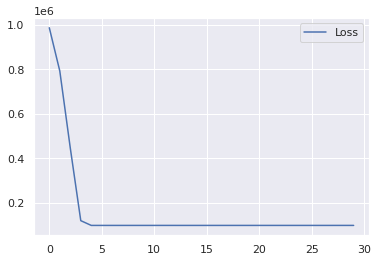

In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

####Predictions & Evaluation

In [ ]:
y_test_pre = model.predict(x_test)
y_test_pre.shape, y_test.shape

((1304, 1), (1304,))

In [ ]:
pa = pd.DataFrame()
pa['Date'] = X_test.reset_index().Date.iloc[1:-1]
pa['Prediction'] = [i[0] for i in y_test_pre][1:]
pa['Actual Values'] = y_test[:-1]
pa.head()

Date   Prediction  Actual Values
1 2012-04-20  1513118.250     1521577.87
2 2012-04-27  1460762.125     1468928.37
3 2012-05-04  1675152.875     1684519.99
4 2012-05-11  1602137.625     1611096.05
5 2012-05-18  1587028.125     1595901.87

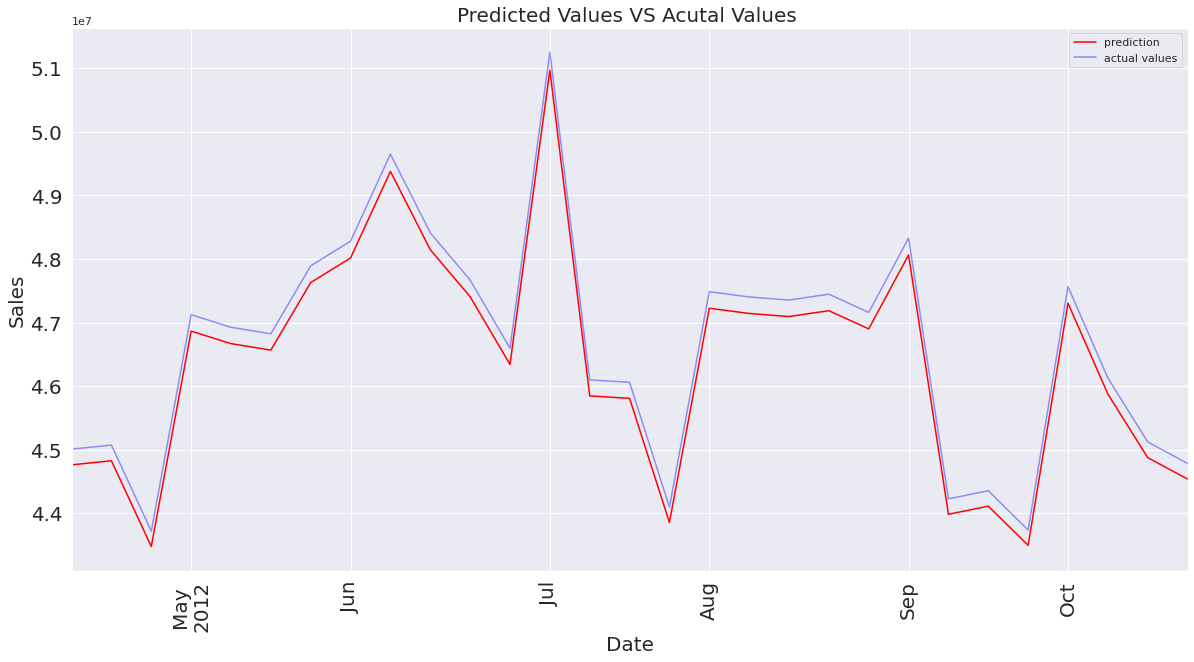

In [ ]:
plt.figure(figsize=(20,10))
pa.groupby('Date')['Prediction'].sum().plot(label='Prediction', color='red', alpha=1)
pa.groupby('Date')['Actual Values'].sum().plot(label='Actual Values', color='blue', alpha=0.4)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Sales', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.title('Predicted vs Actual Sales', fontsize=20)
plt.legend()
plt.show()

In [ ]:
def RMSE(actual, prediction):
    return np.sqrt(mean_squared_error(actual, prediction))

print("RMSE:", RMSE(y_test[:-1], [i[0] for i in y_test_pre][1:]))

6424.876724935636


####Per‑Store Evaluation

In [ ]:
EachStore_df = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).reset_index()
EachStore = EachStore_df.Store

def normalization_train_test_split(store):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(store.drop(columns=['Weekly_Sales','Store','Date']))
    scaled_df = pd.DataFrame(scaled, columns=store.drop(columns=['Weekly_Sales','Store','Date']).columns)
    scaled_df['Weekly_Sales'] = store.Weekly_Sales.values

    # Train/test split
    X_train, X_test, Y_train, Y_test = train_test_split(scaled_df)

    # Build train/test DataFrames
    train_data = pd.DataFrame(X_train)
    train_data['Weekly_Sales'] = Y_train
    test_data = pd.DataFrame(X_test)
    test_data['Weekly_Sales'] = Y_test

    # Reshape for supervised learning
    x_train, x_test, y_train, y_test = reshape_data(train_data, test_data)
    return x_train, x_test, y_train, y_test

20 - RMSE: 44829.8026520933
4 - RMSE: 7866.232198514666
14 - RMSE: 9732.506810940646
13 - RMSE: 17716.2447205924
2 - RMSE: 12316.224393828206
10 - RMSE: 4906.210804687461
27 - RMSE: 3315.004051204406
6 - RMSE: 73.60695113610744
1 - RMSE: 12114.291708100109
39 - RMSE: 7859.298577571196
19 - RMSE: 1320.218094234862
31 - RMSE: 4319.640000115689
23 - RMSE: 3228.158512692761
24 - RMSE: 11592.919147034767
11 - RMSE: 6870.756149820485
28 - RMSE: 41487.77941248514
41 - RMSE: 4878.421745788582
32 - RMSE: 8724.896747809722
18 - RMSE: 6591.099339397998
22 - RMSE: 6277.877109158112
12 - RMSE: 5207.021599912308


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


26 - RMSE: 3228.382197698137


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


34 - RMSE: 2492.72942151483


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


40 - RMSE: 8733.626769813154


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


35 - RMSE: 3783.3405504830926


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


8 - RMSE: 3583.2579825120847


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


17 - RMSE: 1375.188330352785


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


45 - RMSE: 3073.286672470476


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


21 - RMSE: 3753.3561649149733


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


25 - RMSE: 4009.8852455801602


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


43 - RMSE: 1131.9637218676883


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


15 - RMSE: 19.49337697359835


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


7 - RMSE: 12628.406191940527


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


42 - RMSE: 20595.89048204195


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


9 - RMSE: 1594.9412379428245


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


29 - RMSE: 1939.4097009401453


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


16 - RMSE: 2027.2446559063007


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


37 - RMSE: 2536.0750580158497


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


30 - RMSE: 1658.86111287782


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3 - RMSE: 5613.581755991333


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


38 - RMSE: 7443.788170877891


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


36 - RMSE: 530.249973378261


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


5 - RMSE: 2388.0990903980373


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


44 - RMSE: 102.9071023403878


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


33 - RMSE: 2573.9606874270326


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


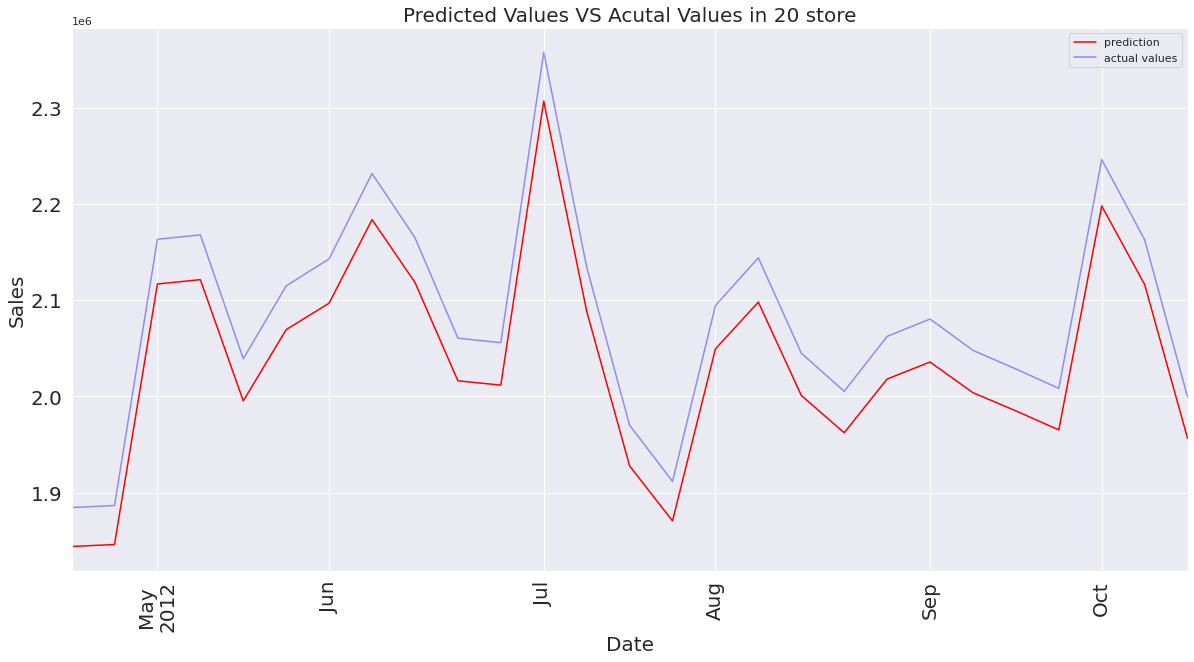

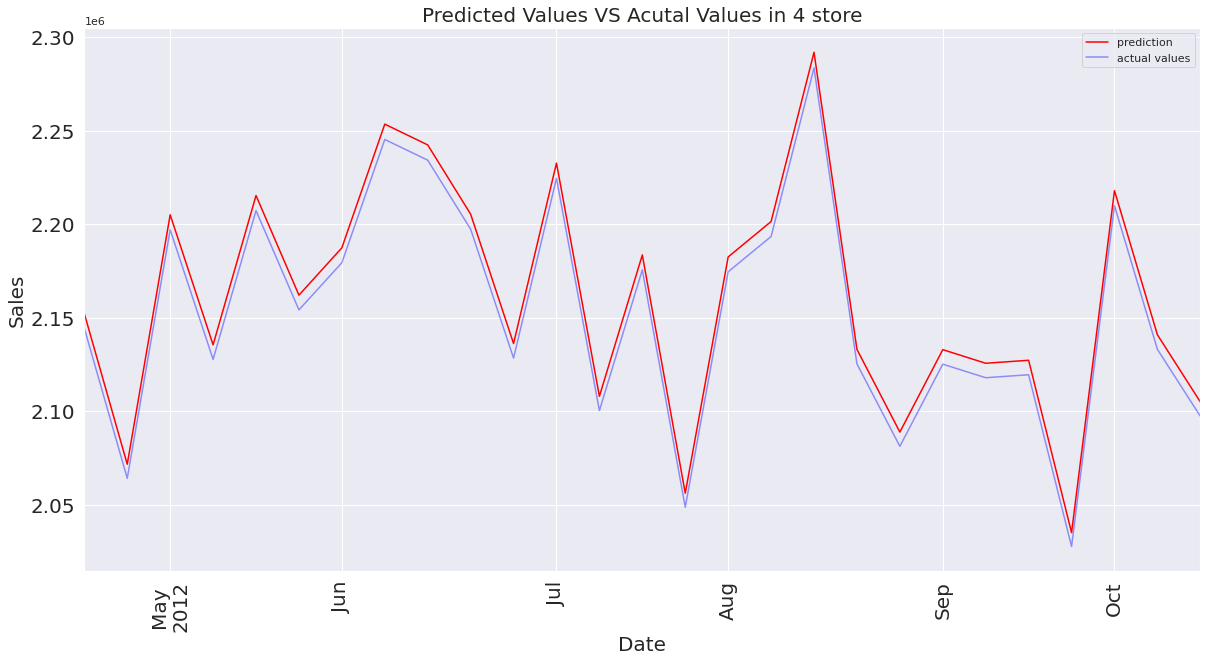

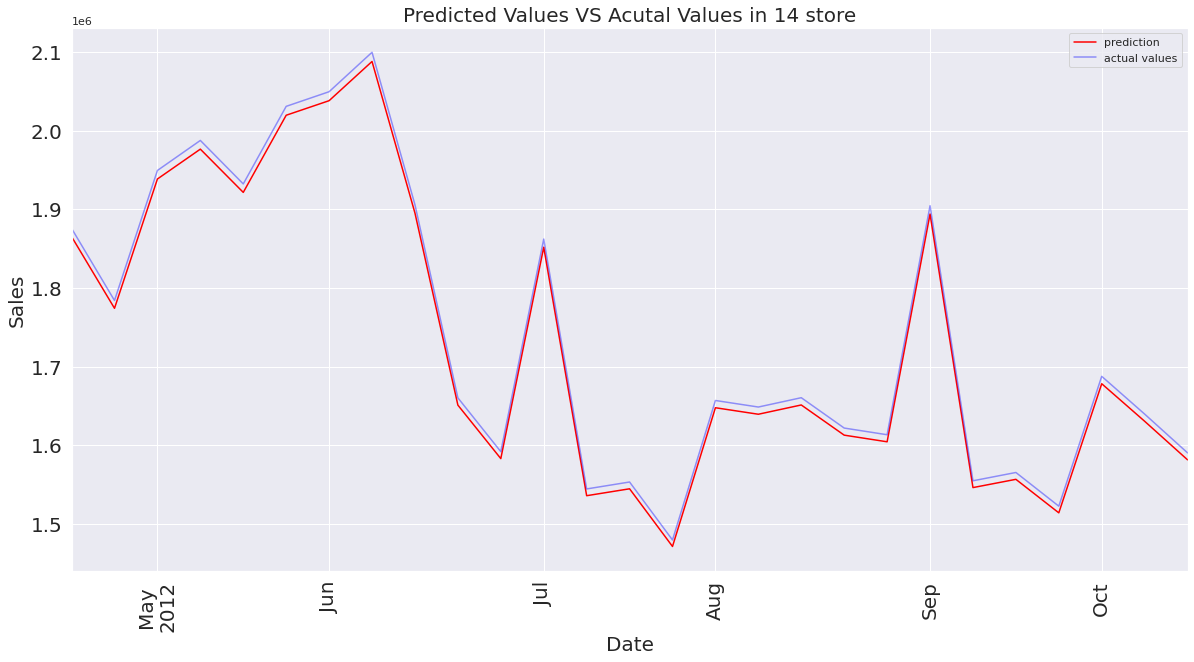

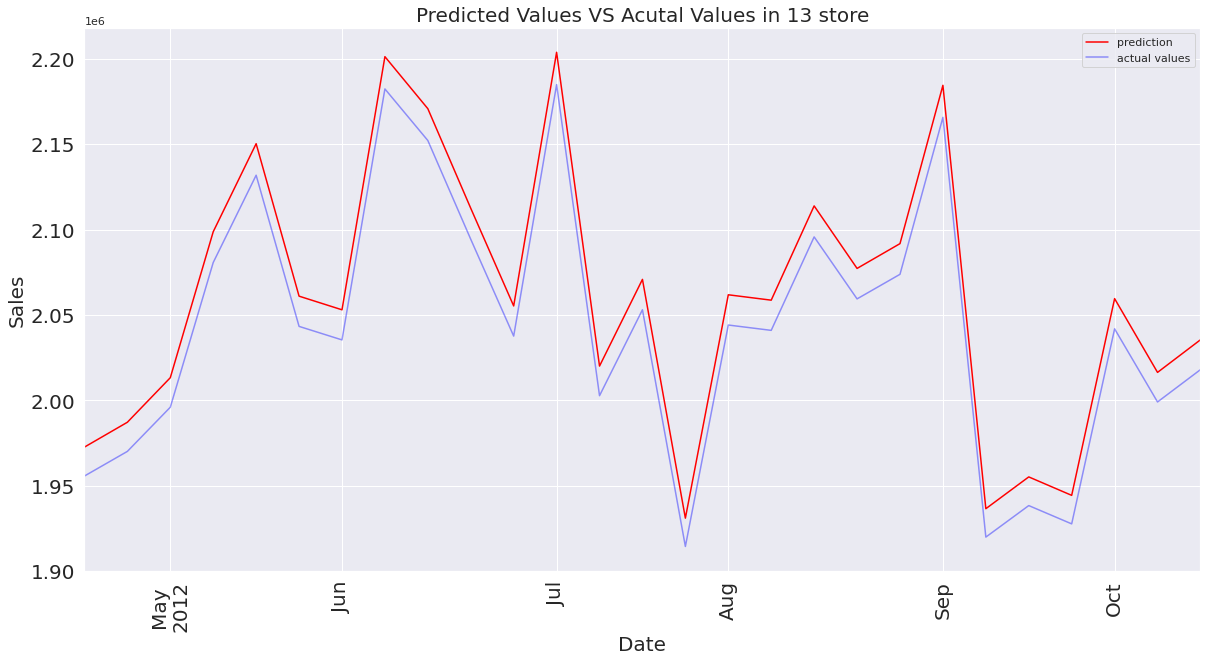

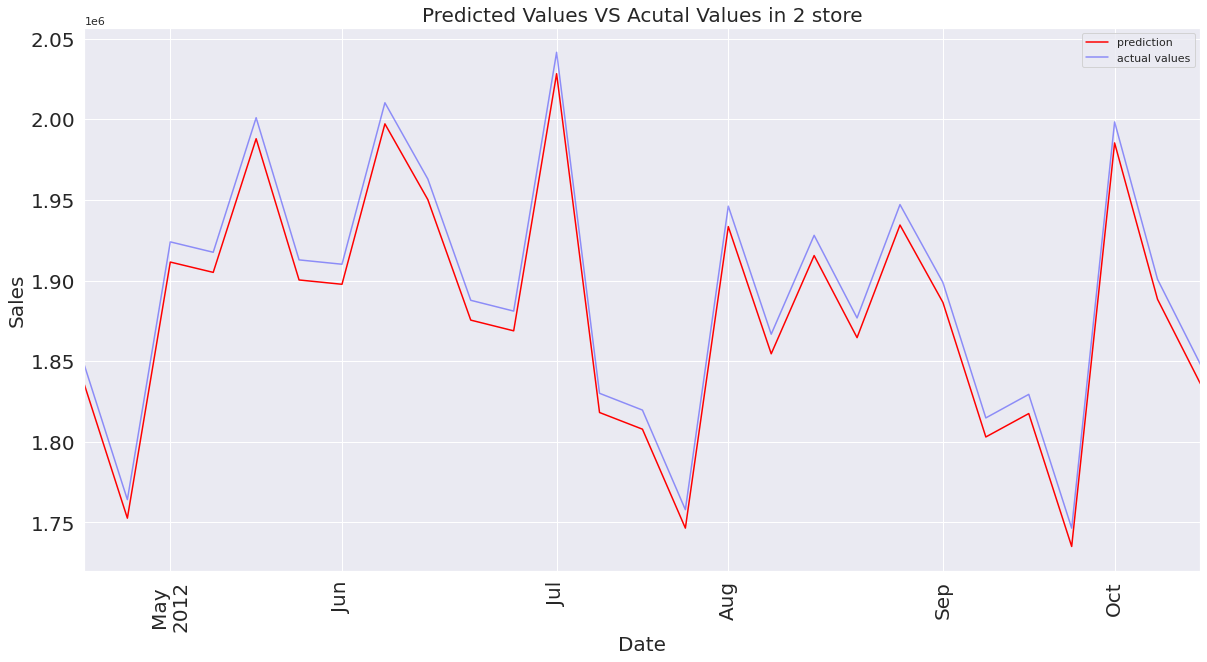

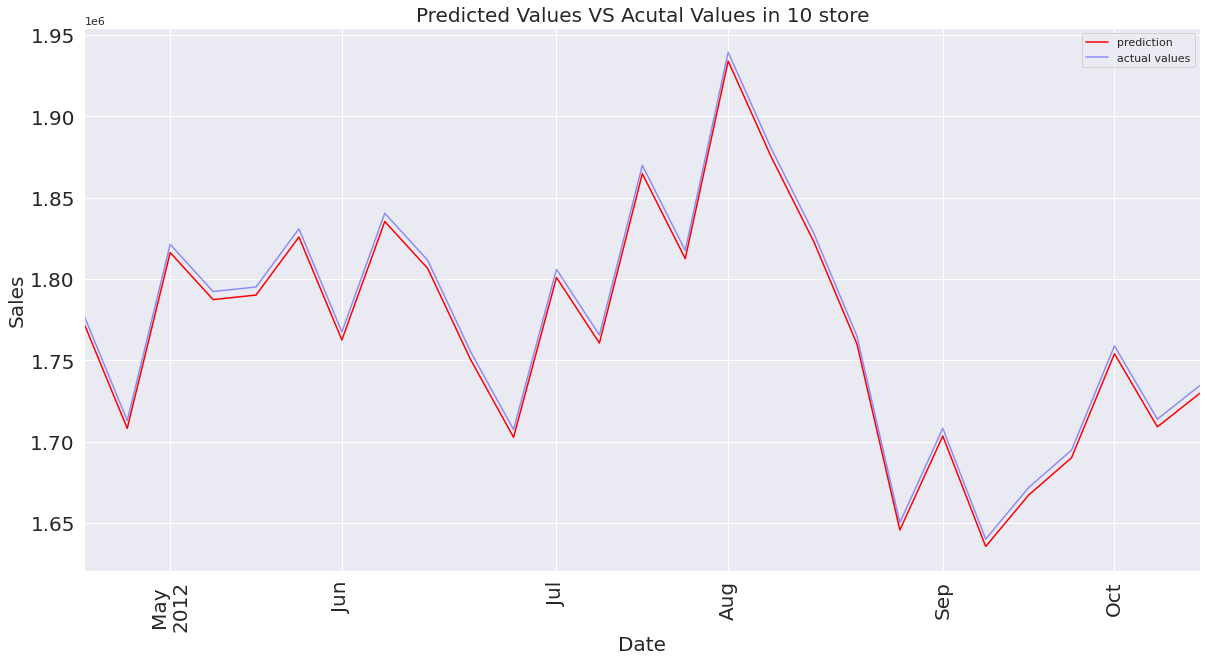

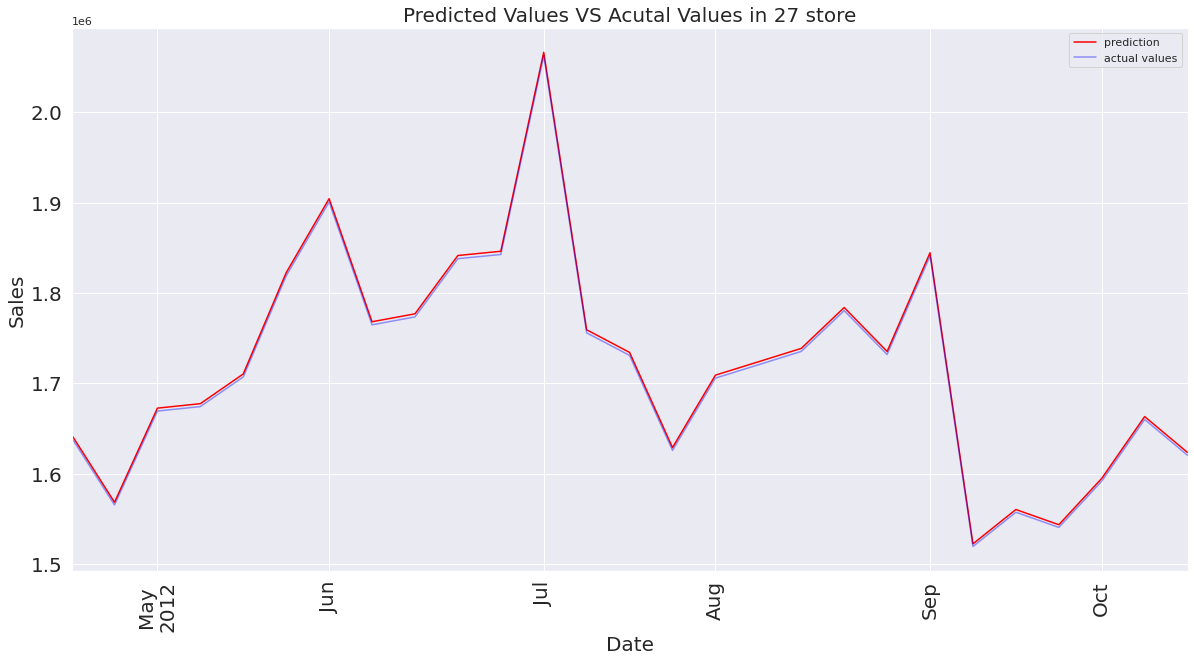

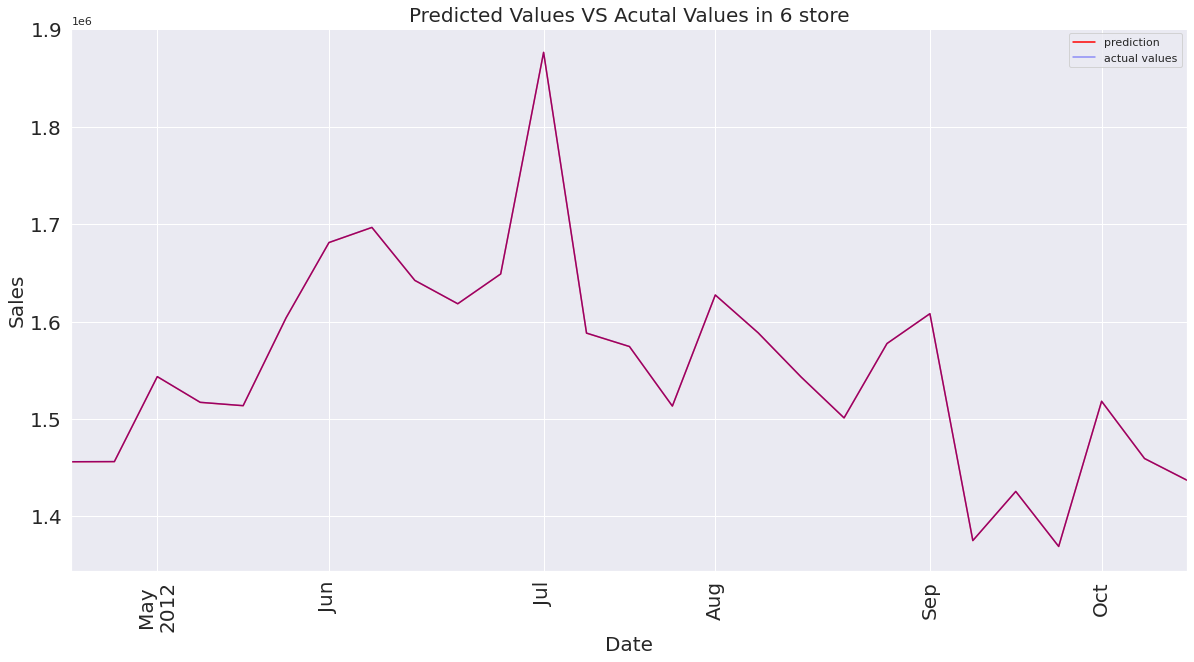

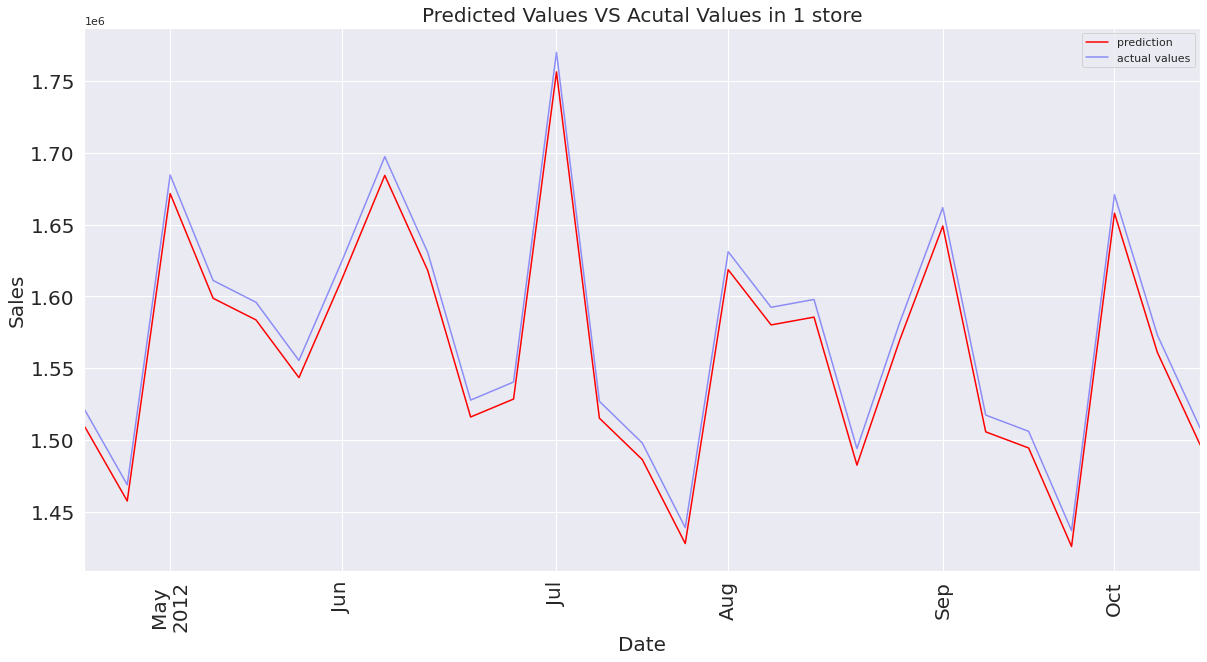

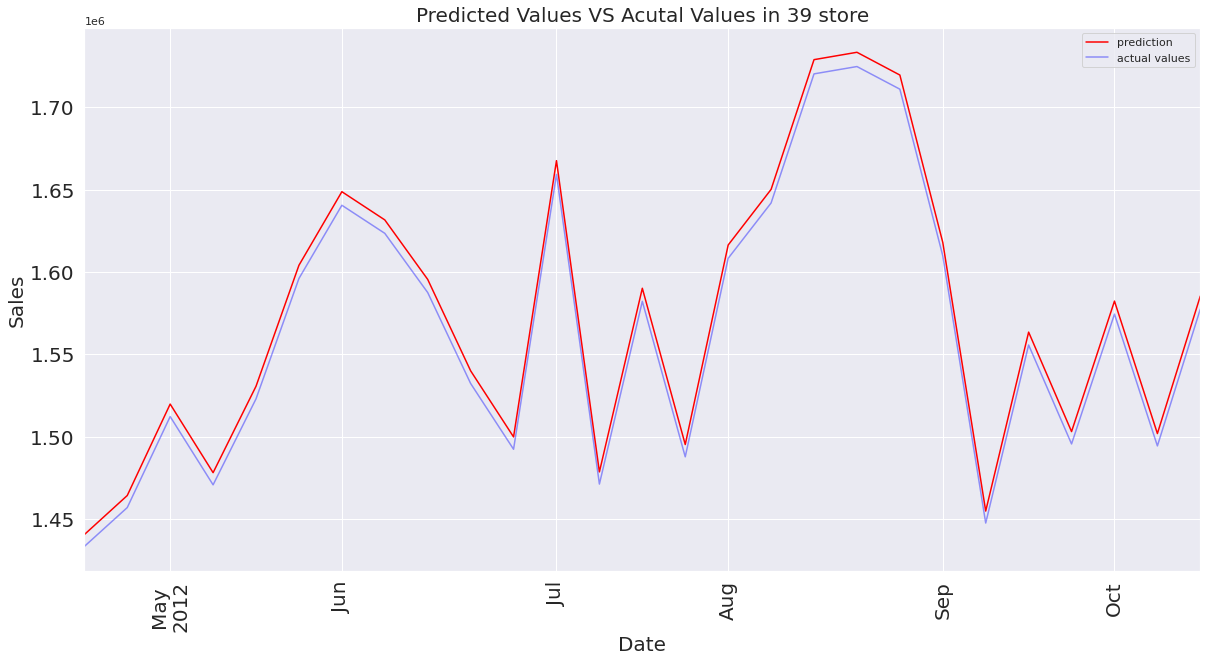

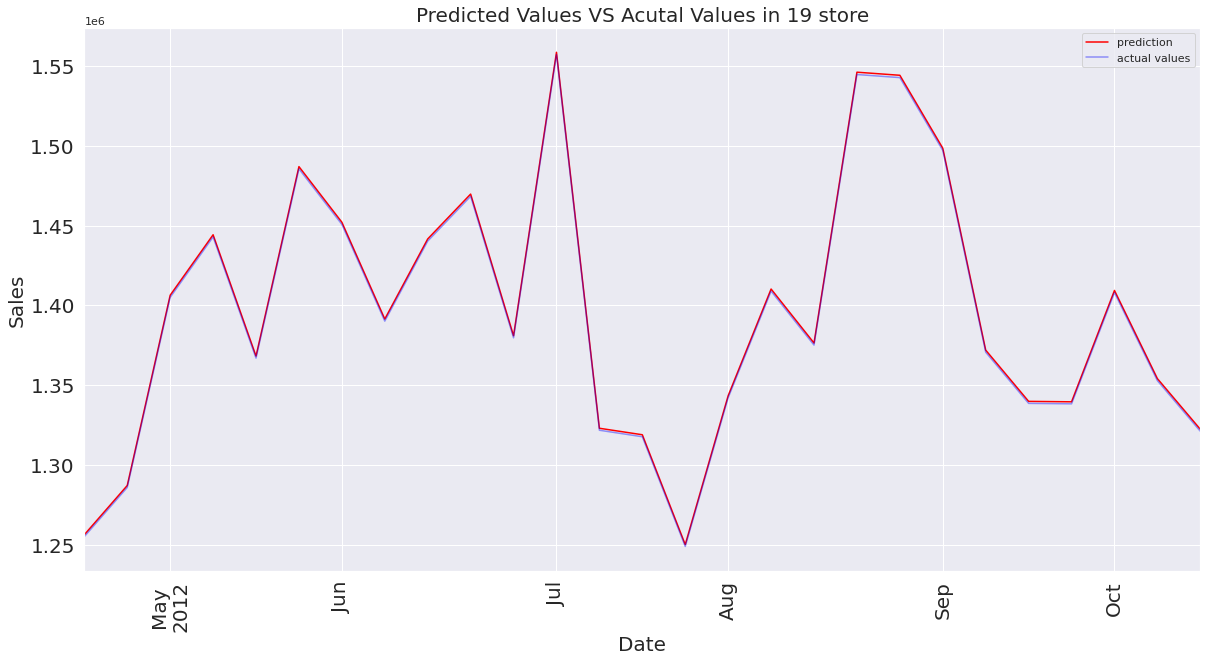

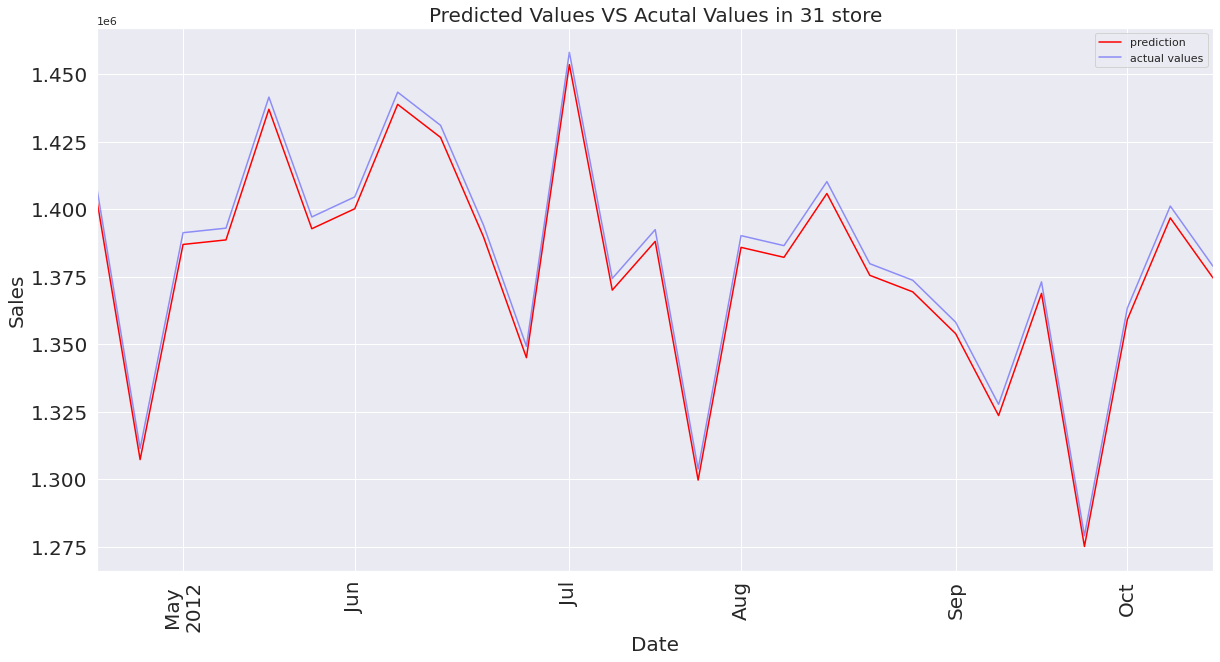

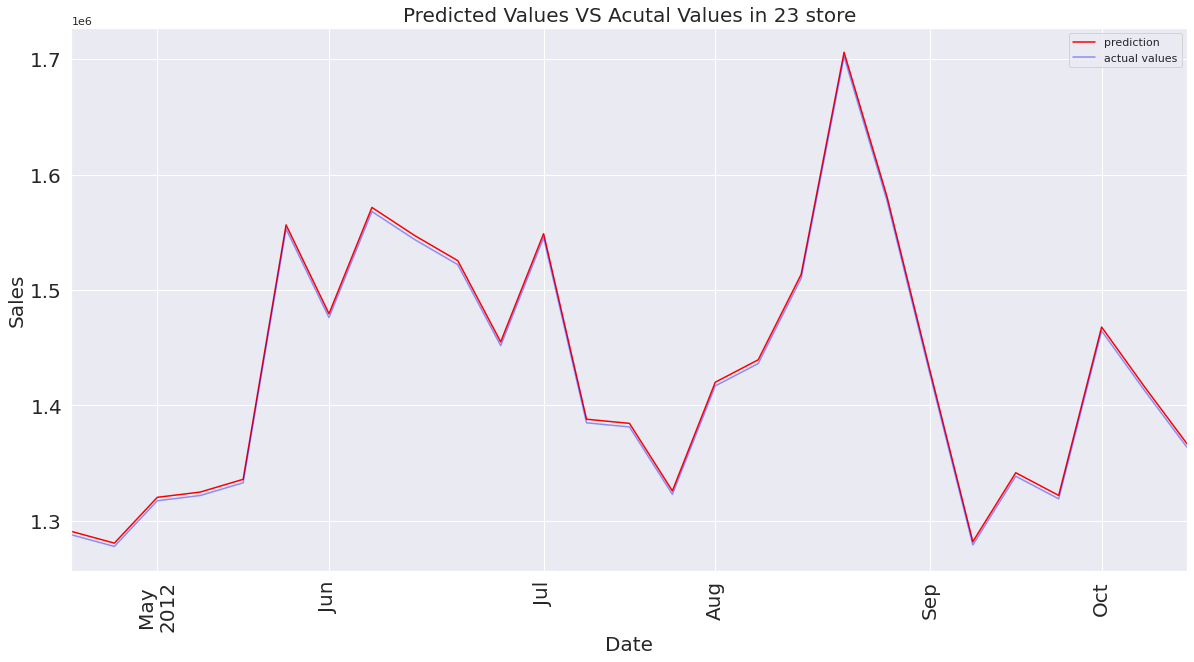

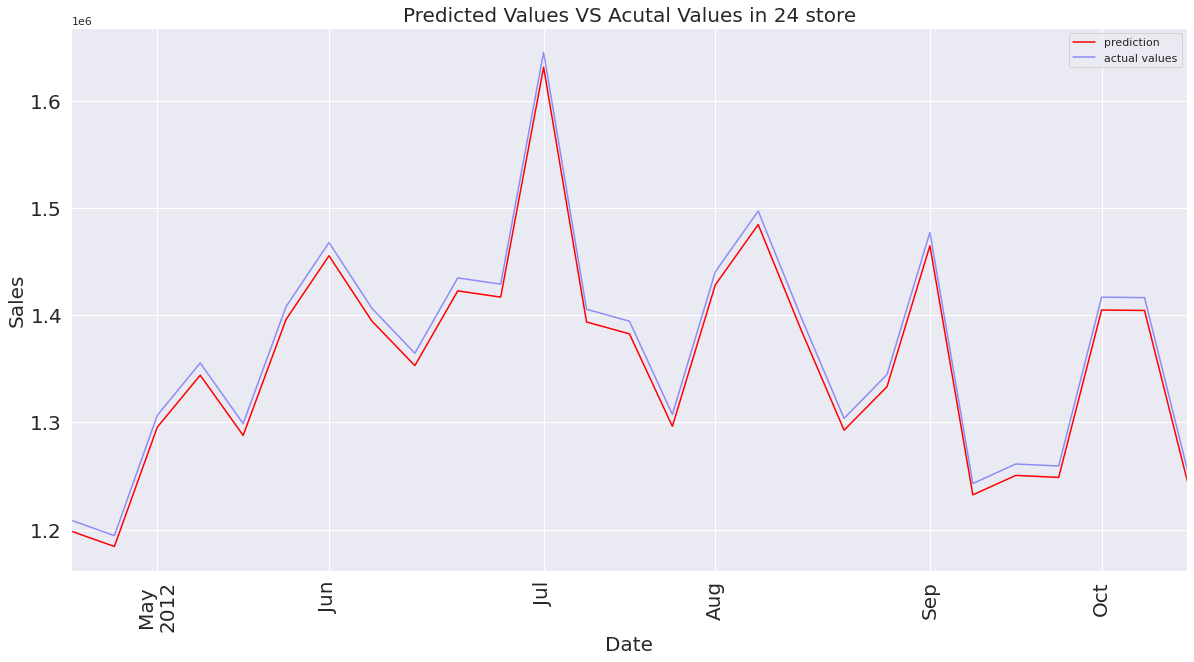

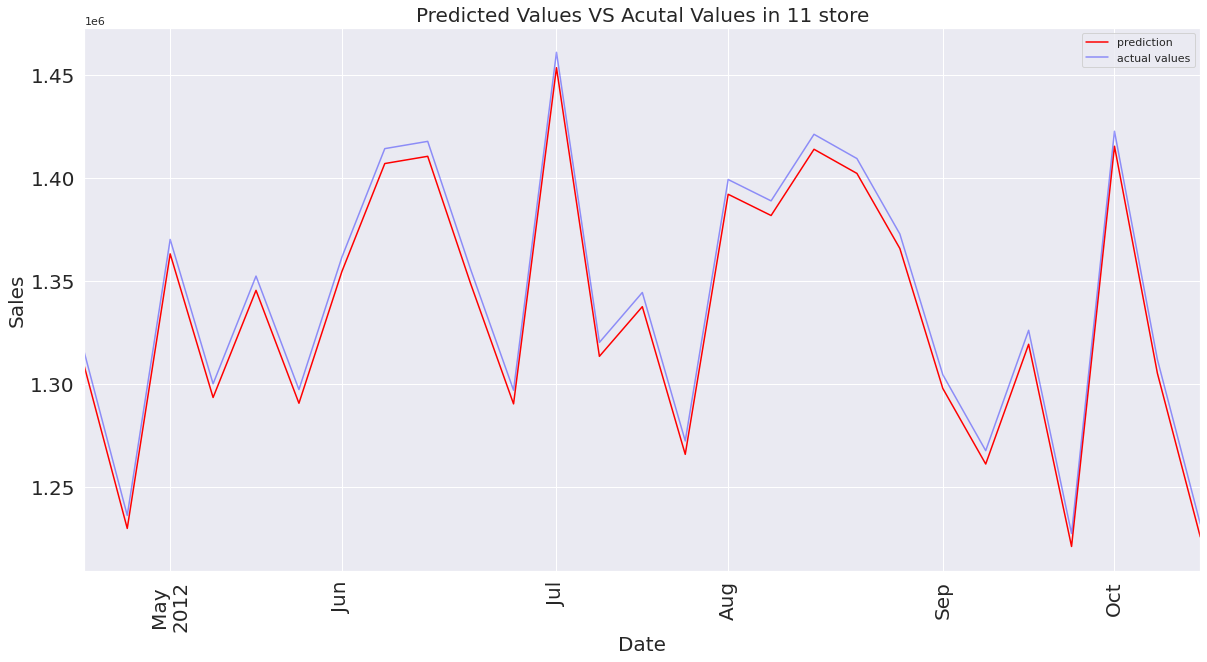

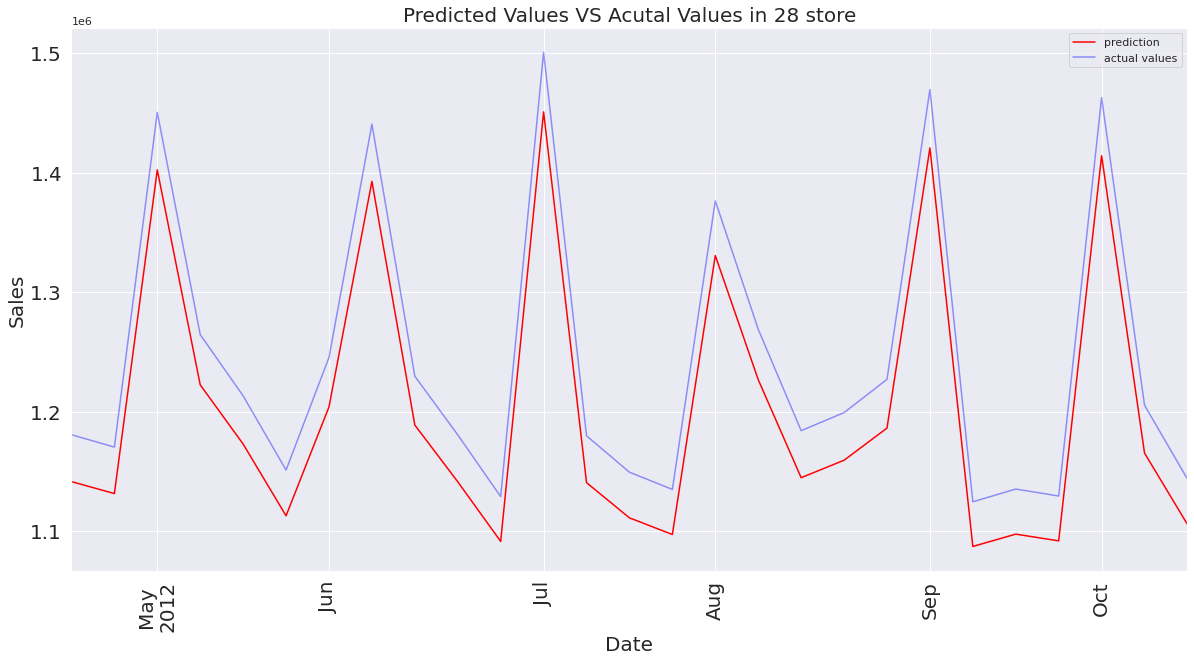

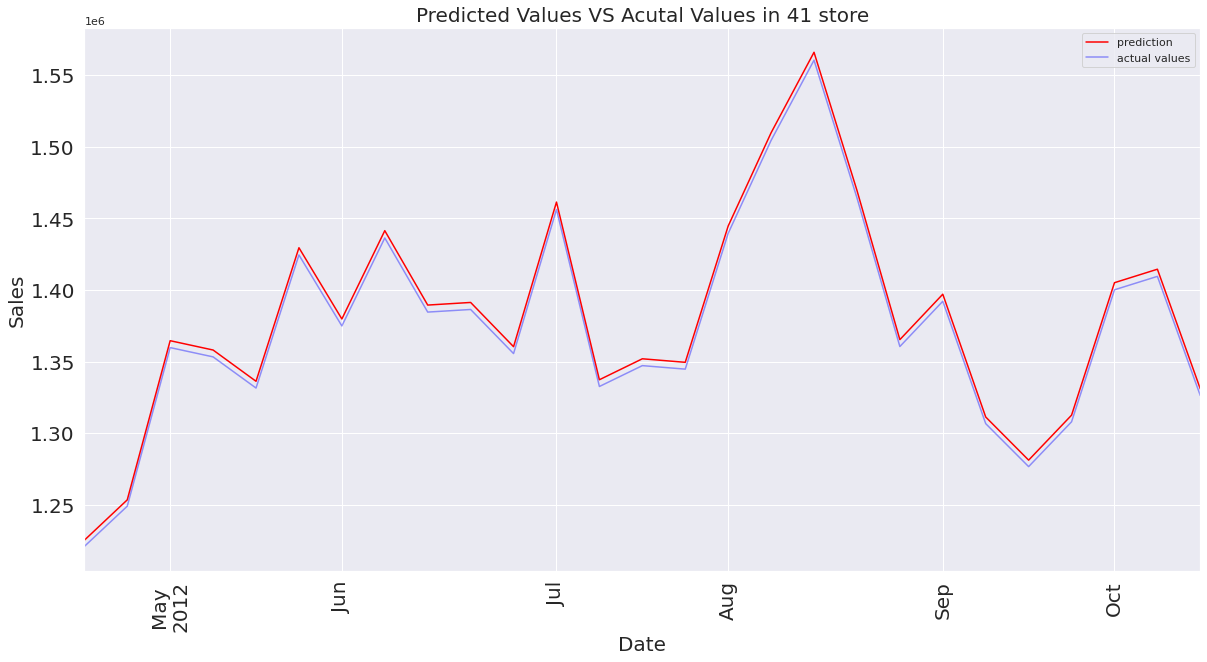

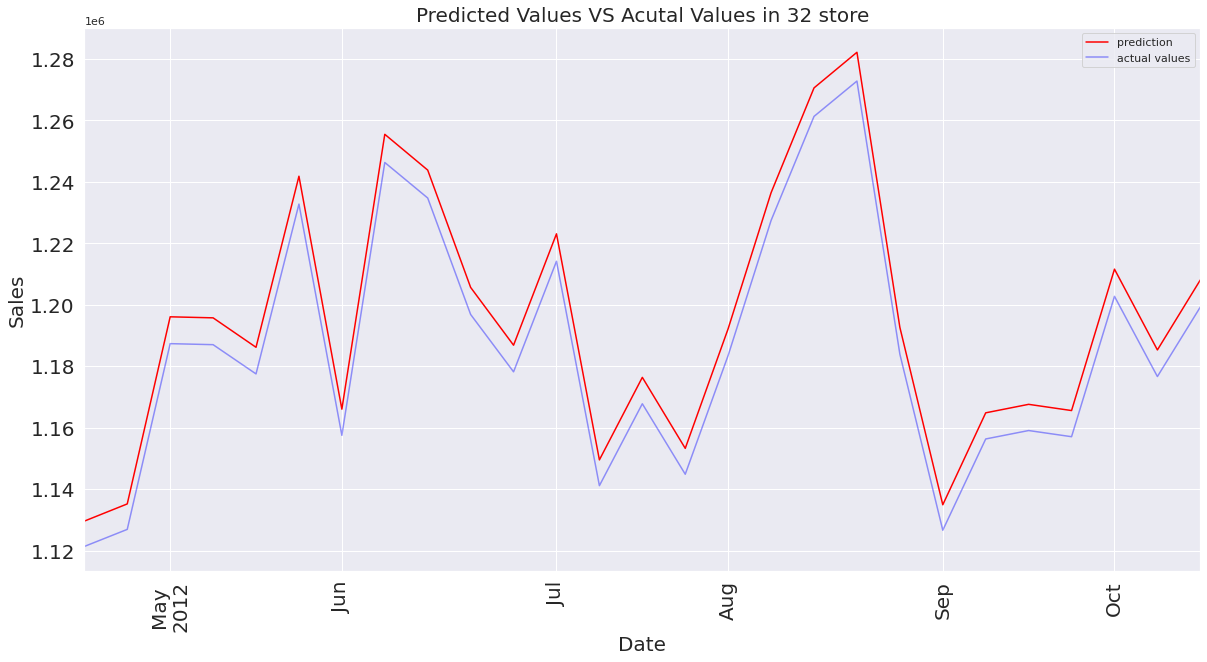

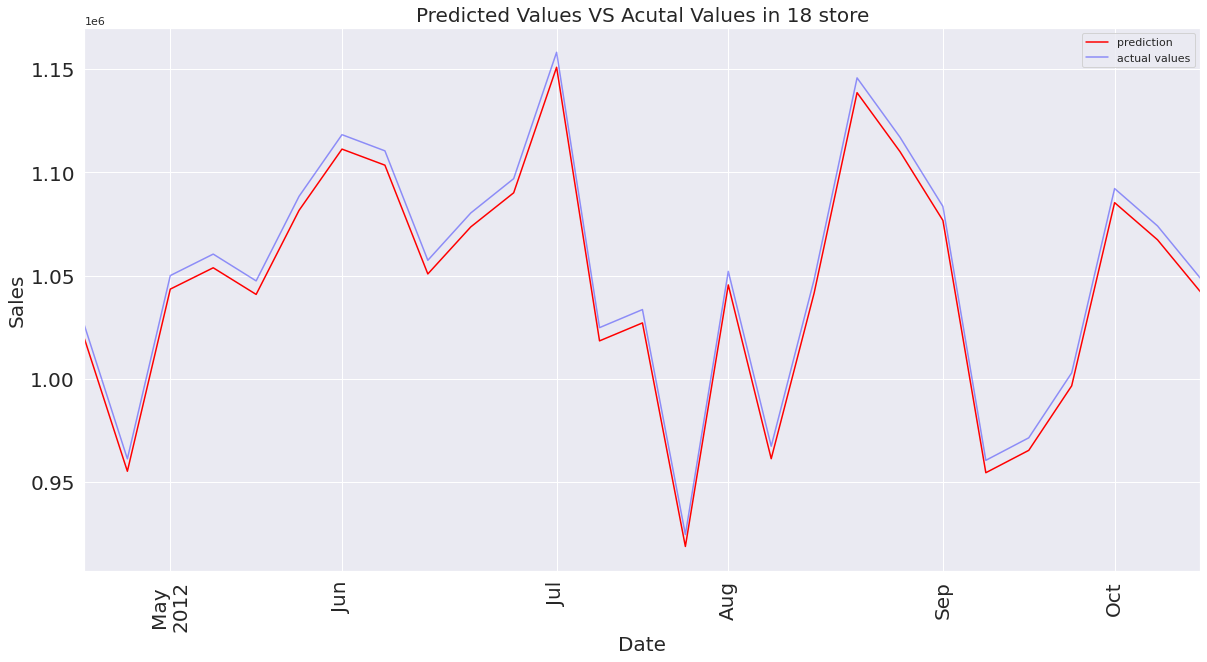

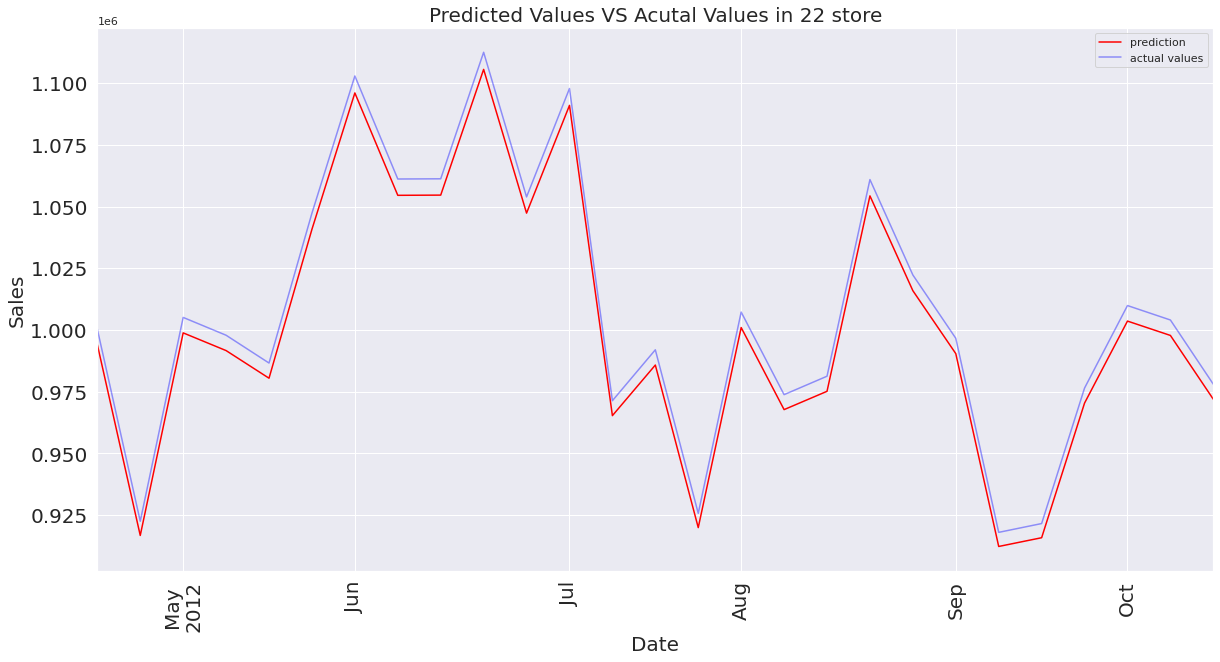

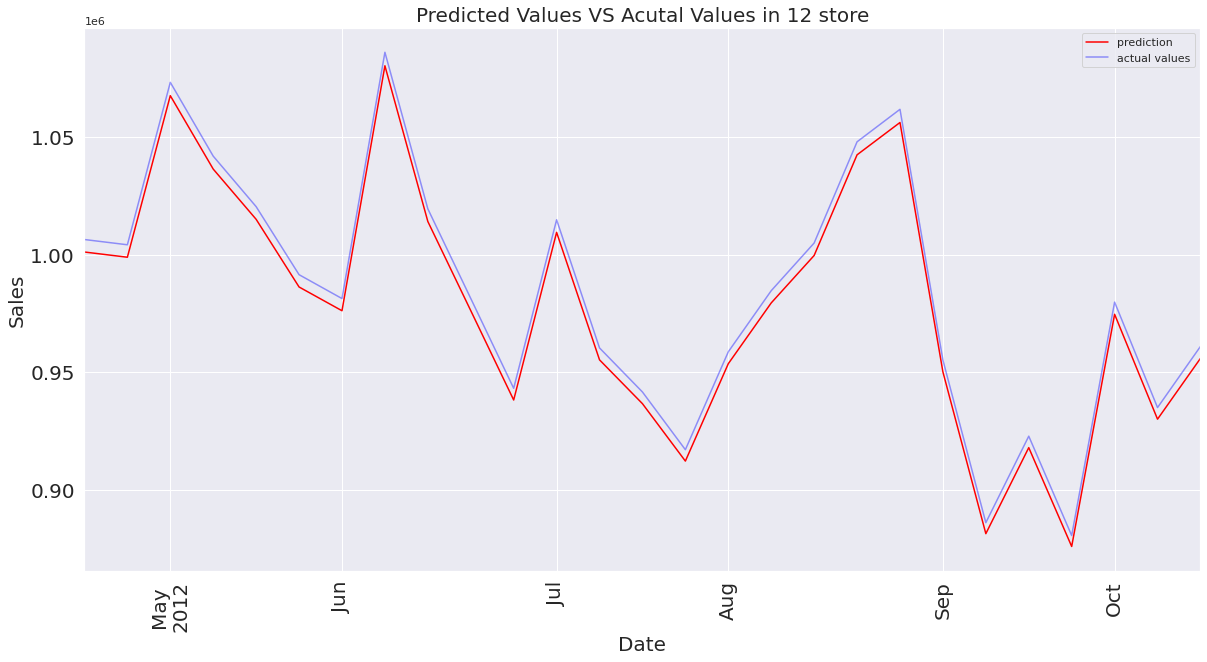

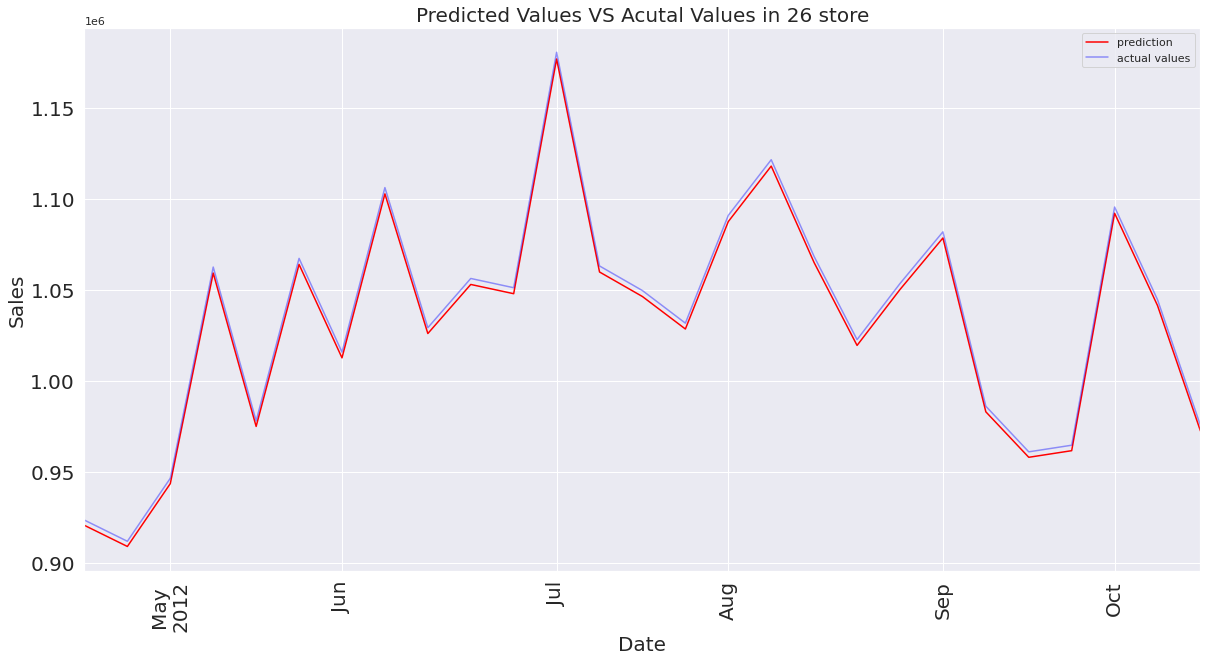

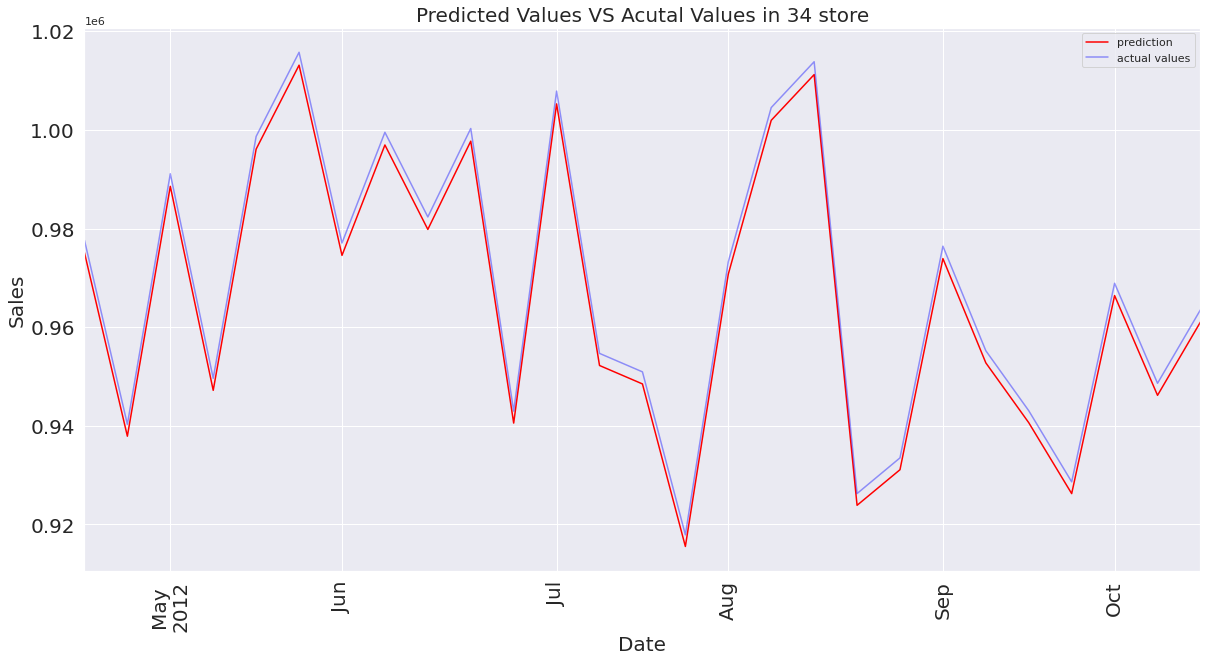

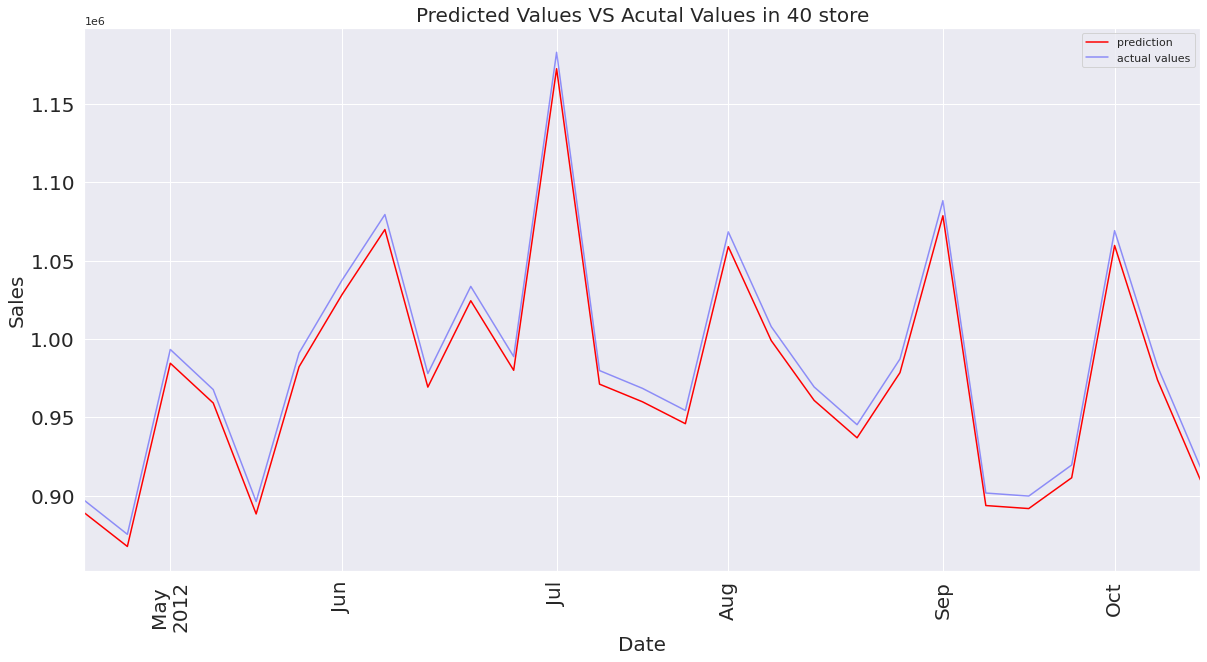

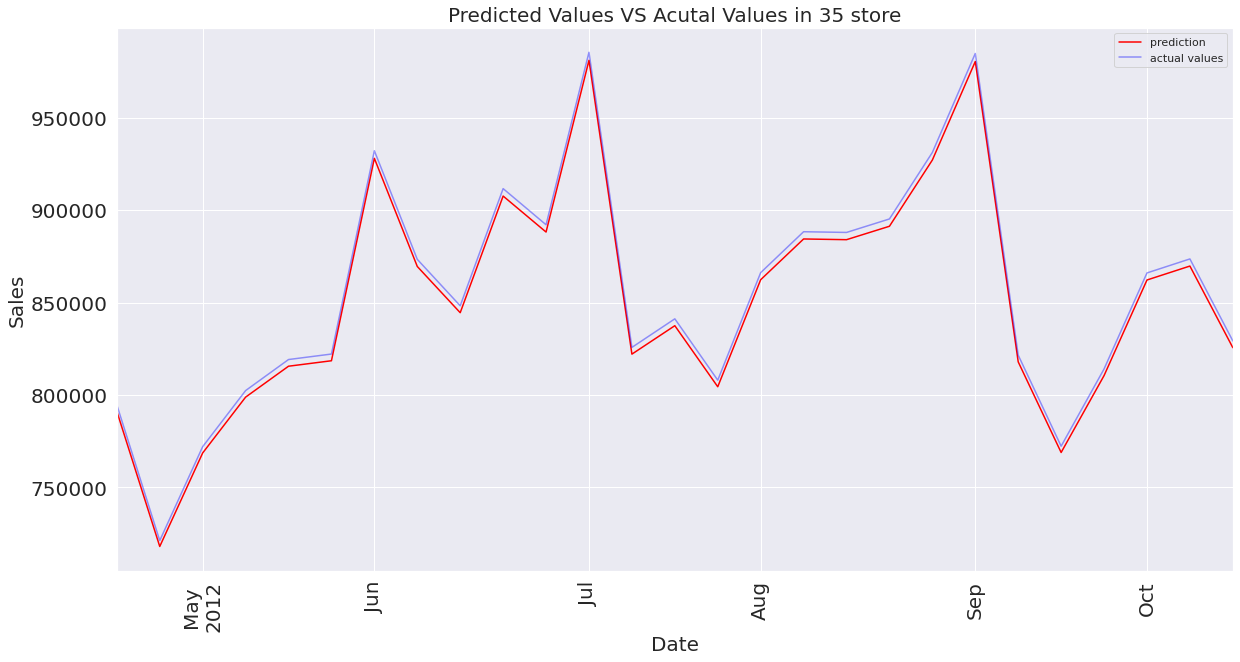

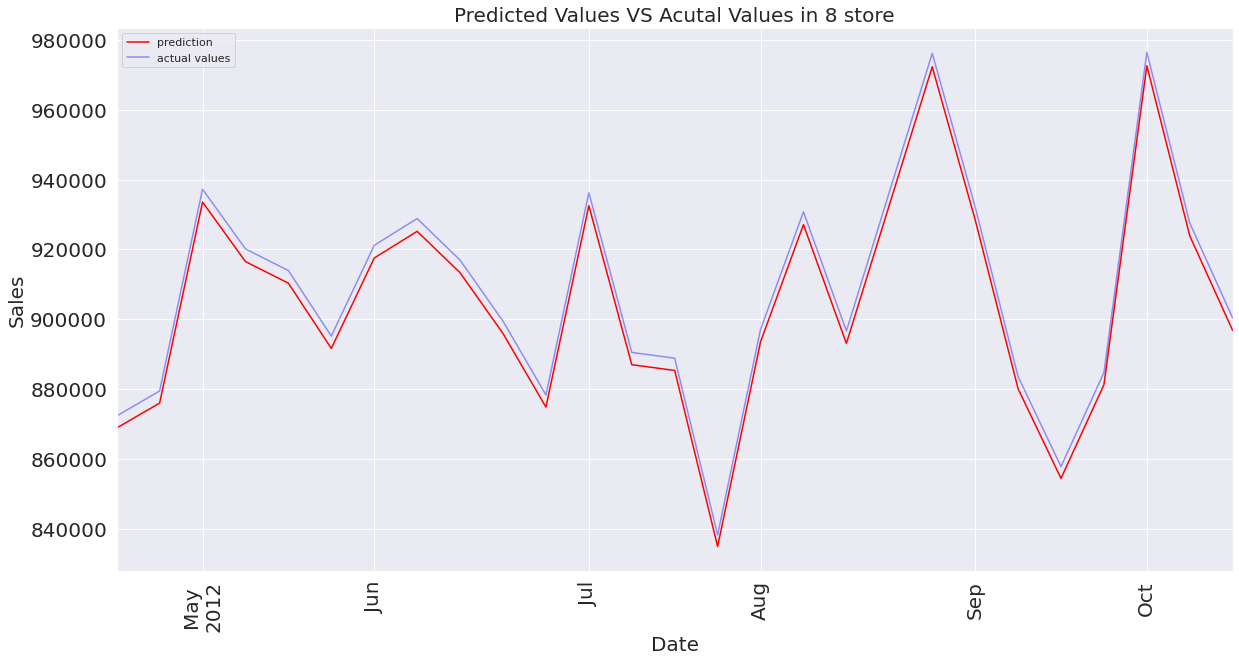

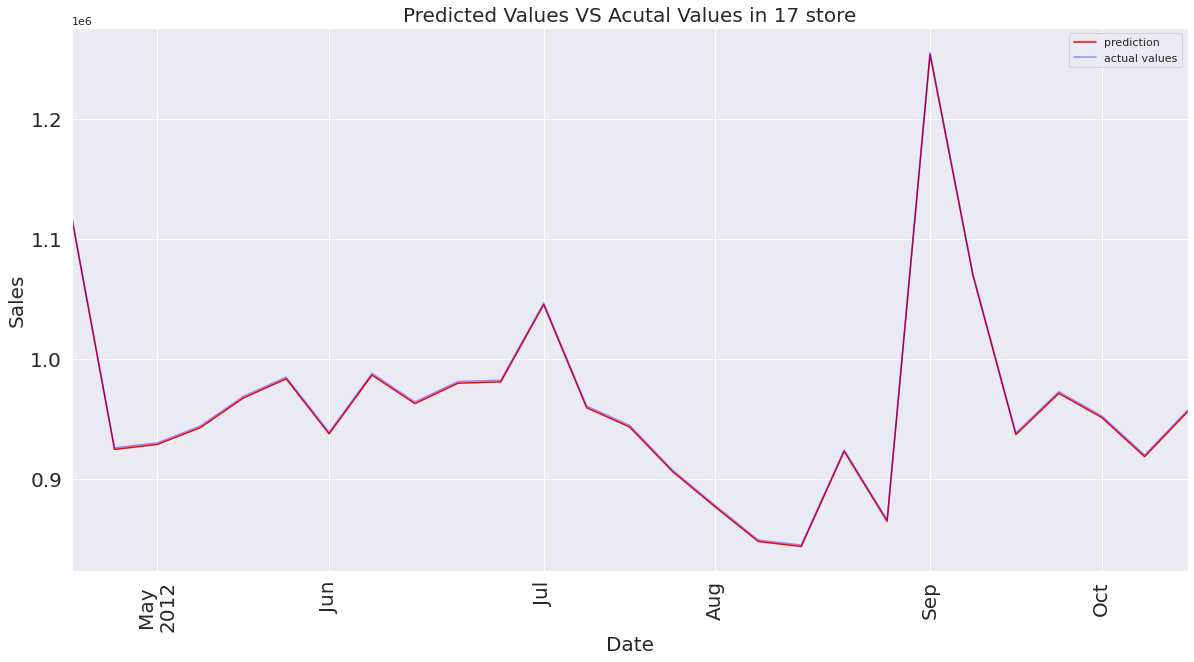

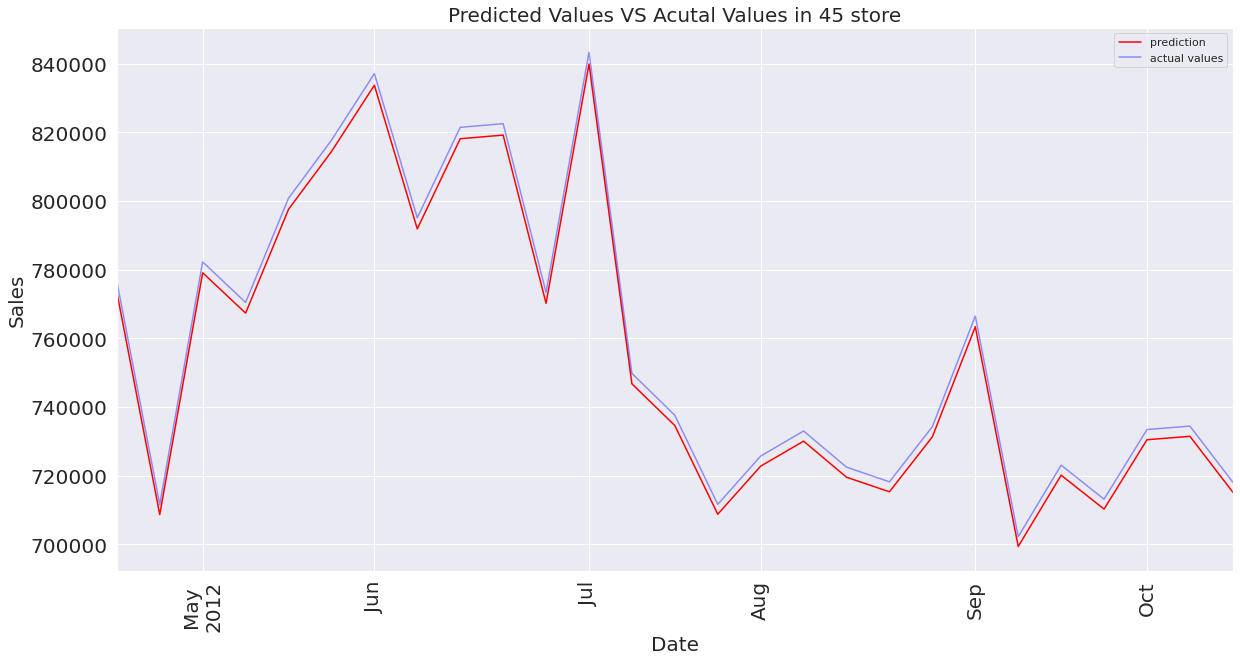

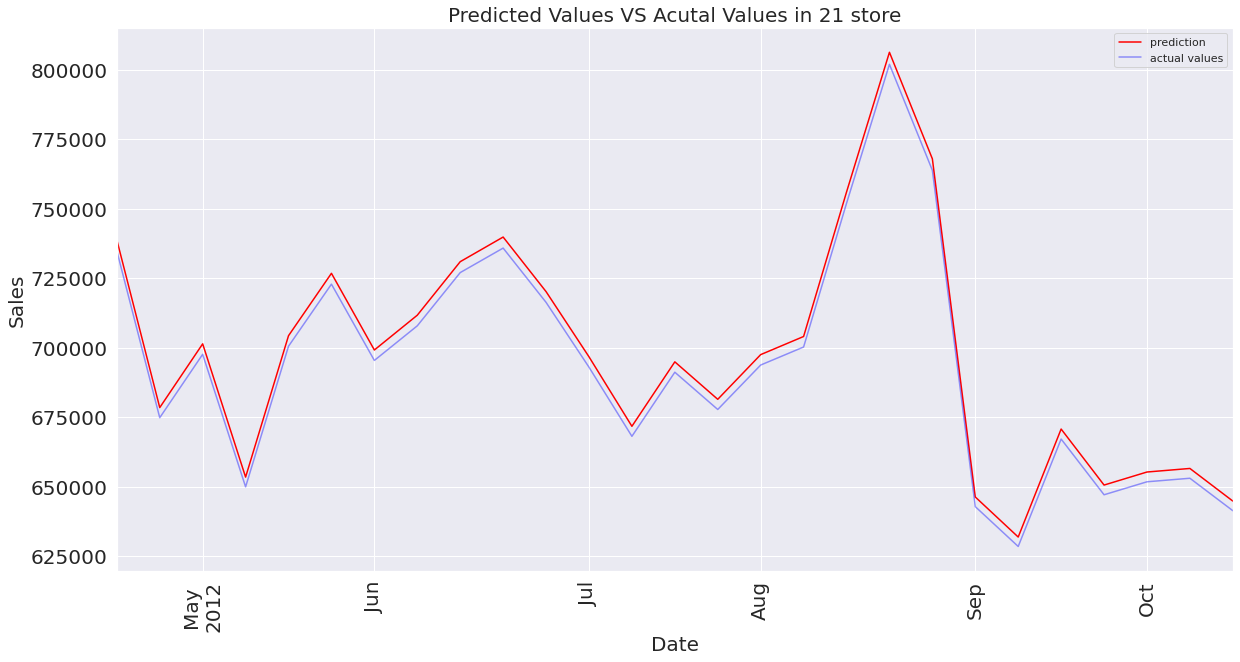

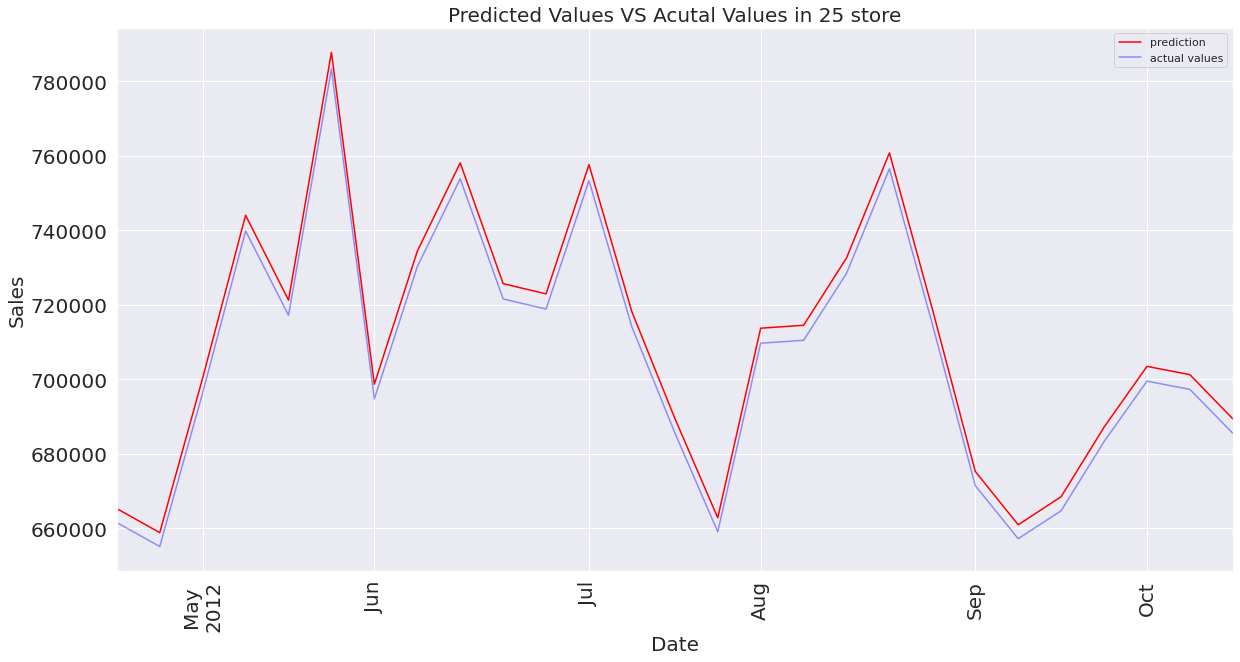

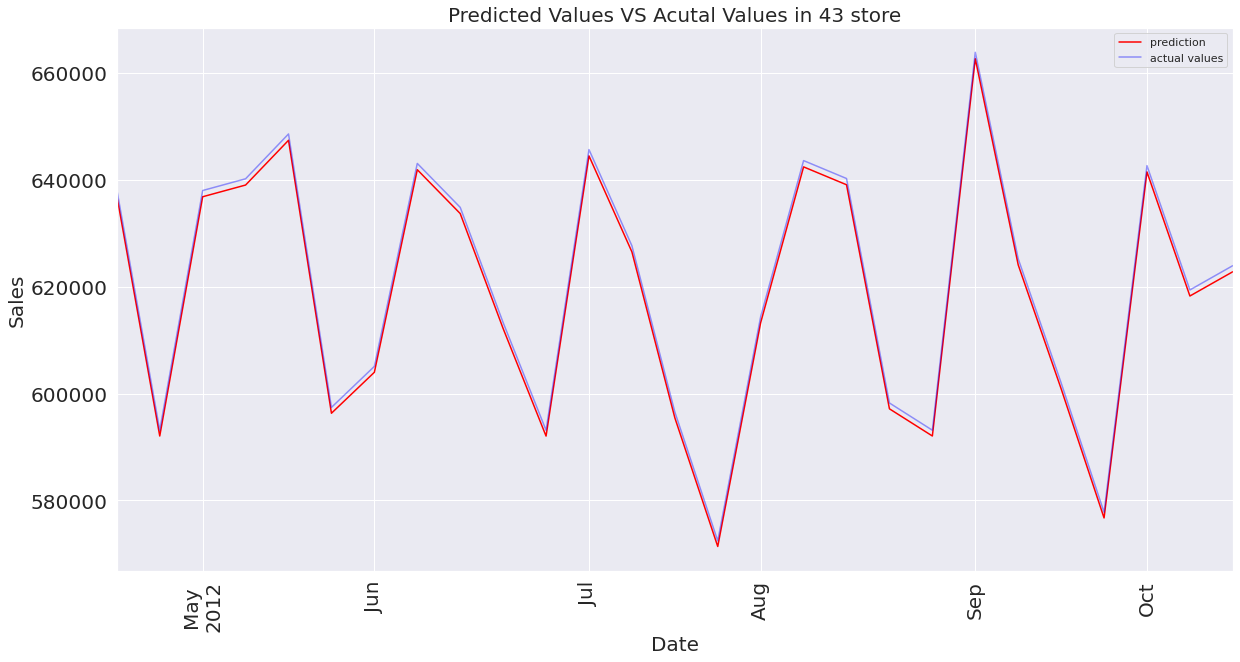

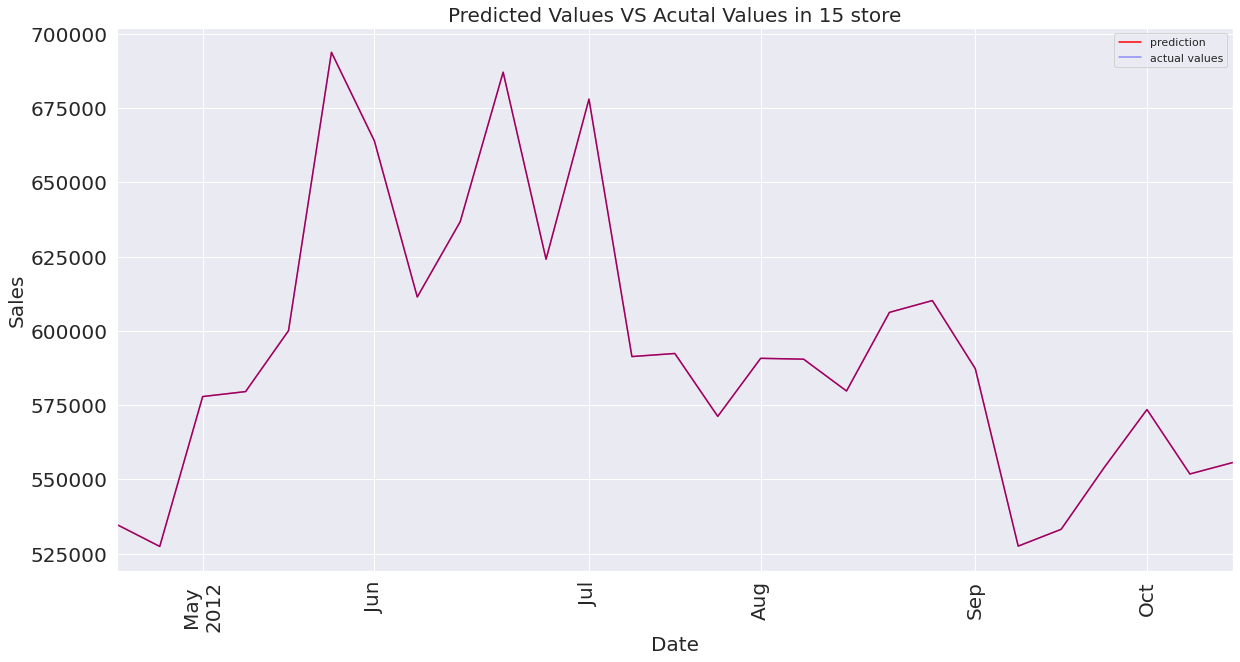

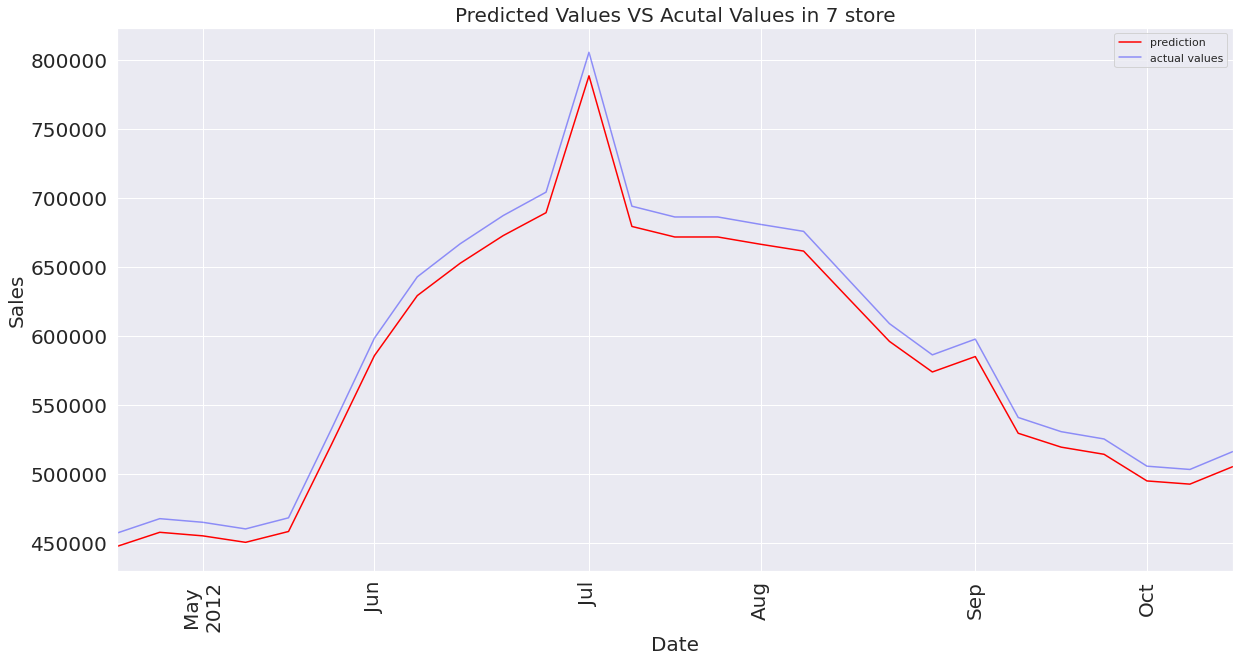

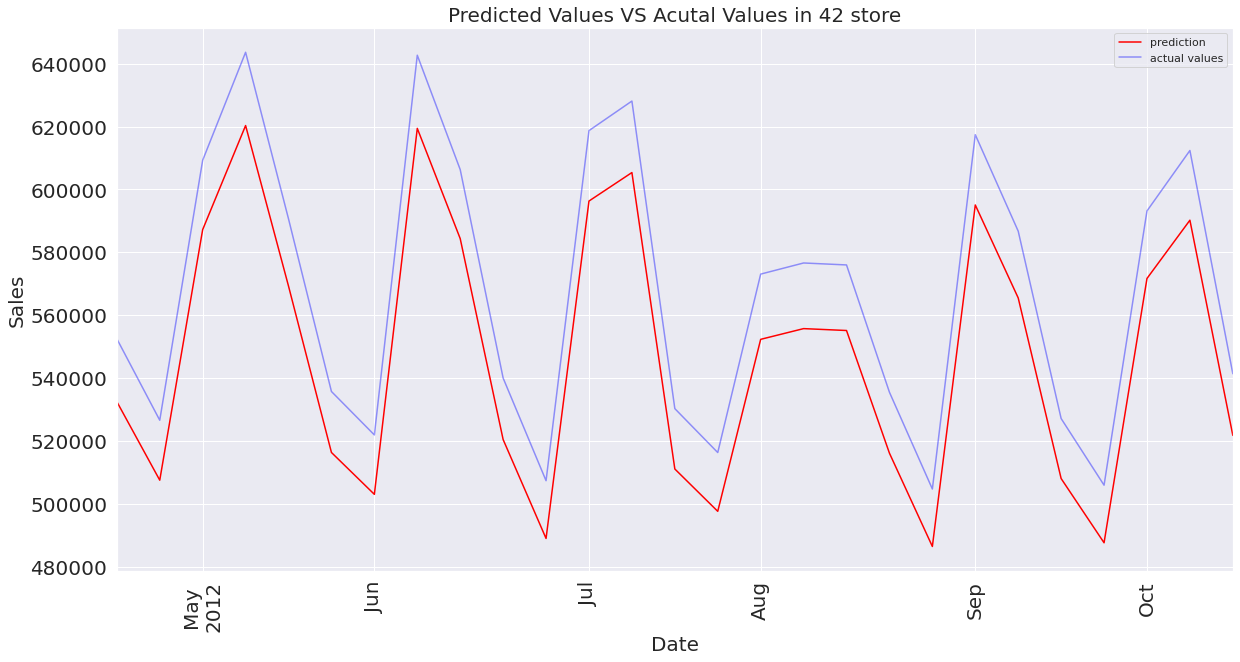

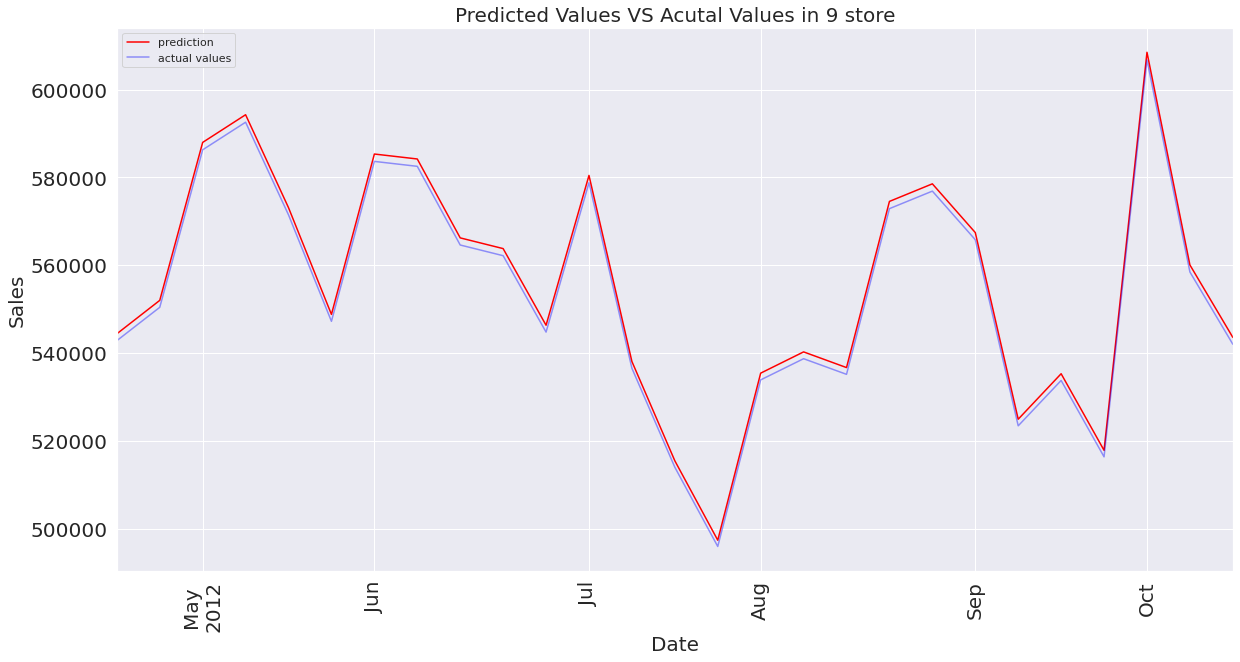

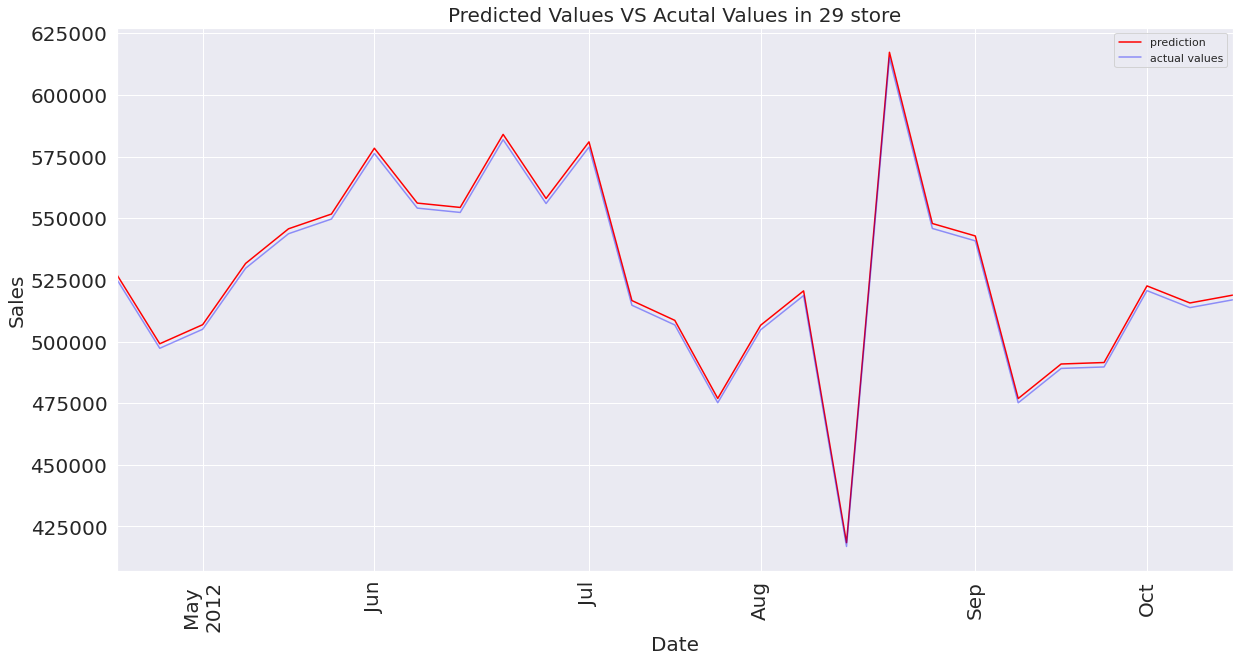

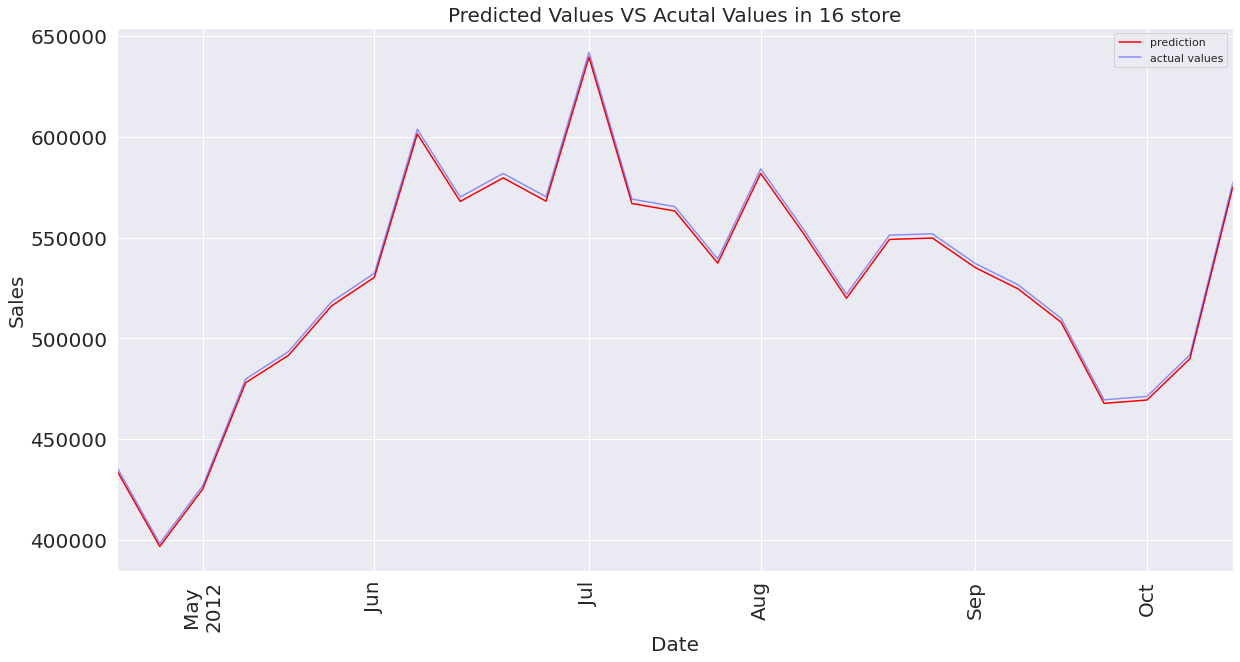

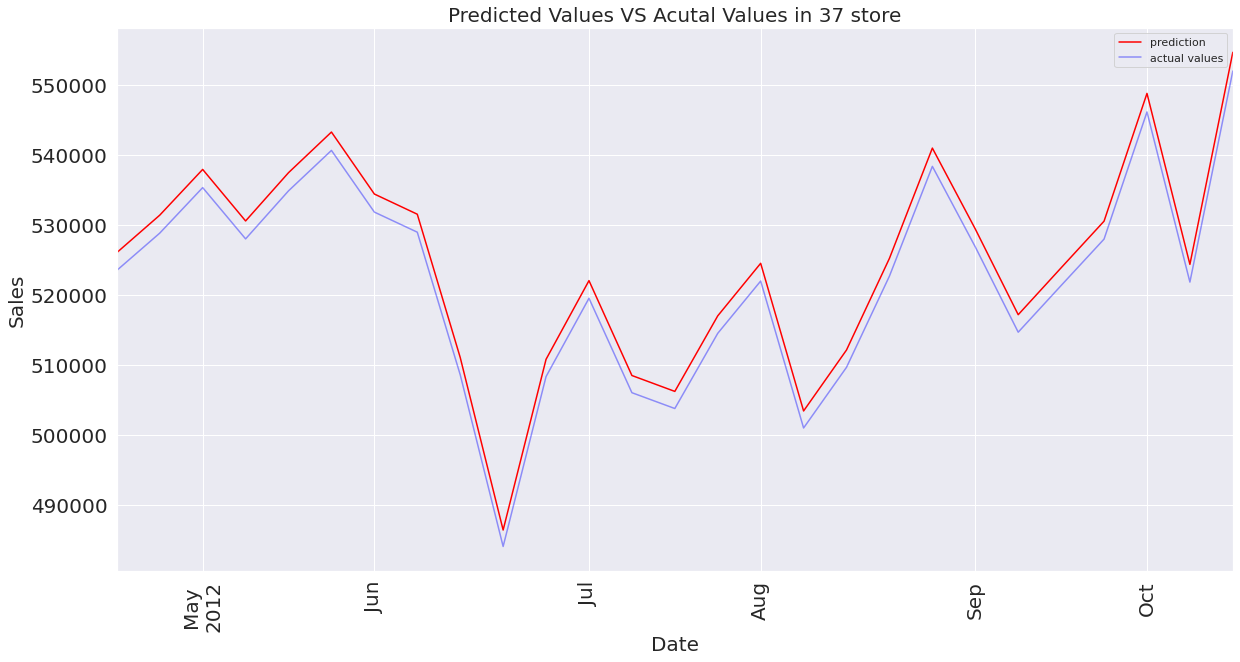

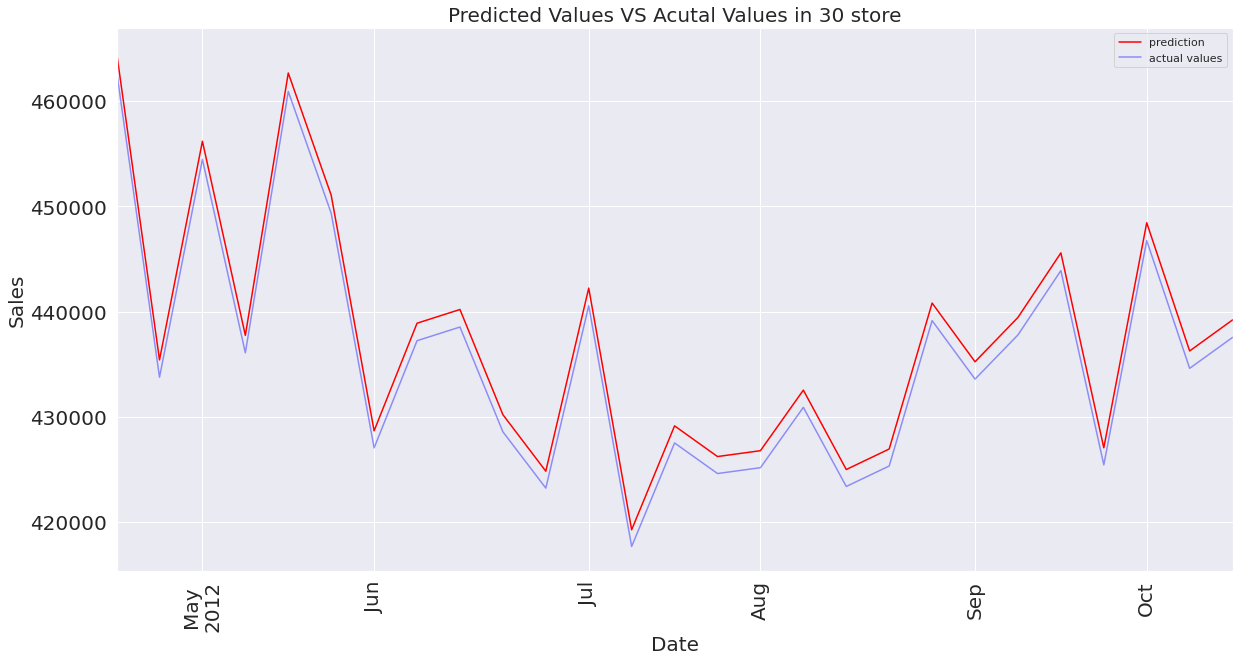

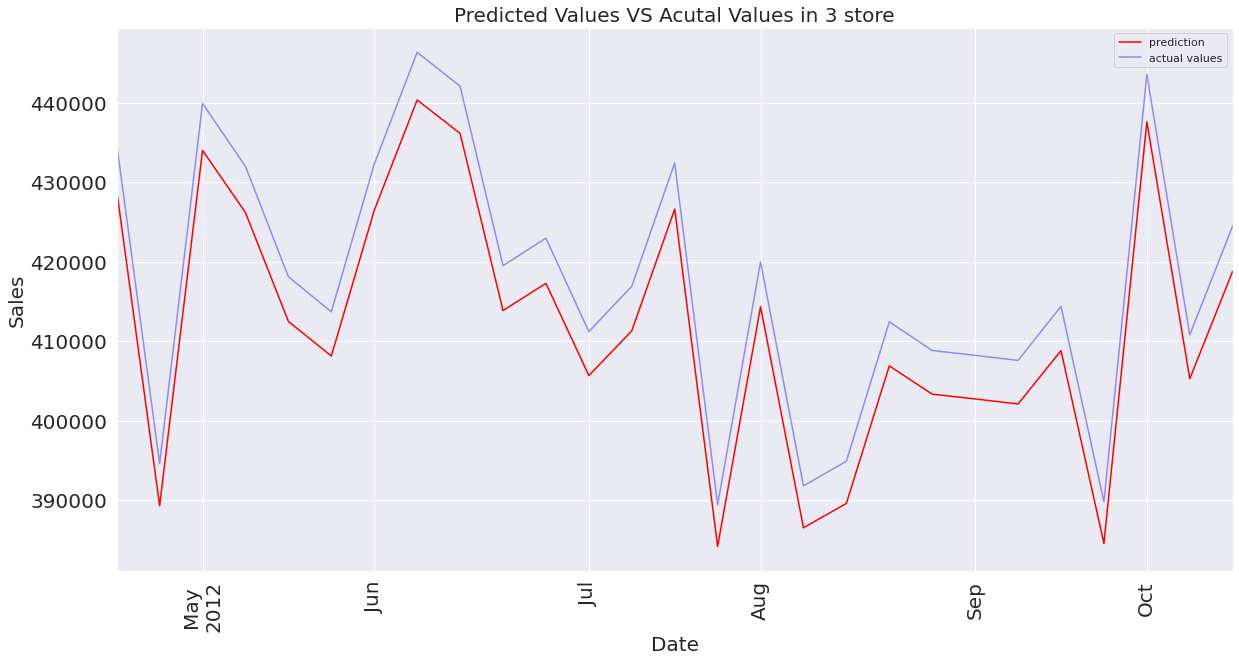

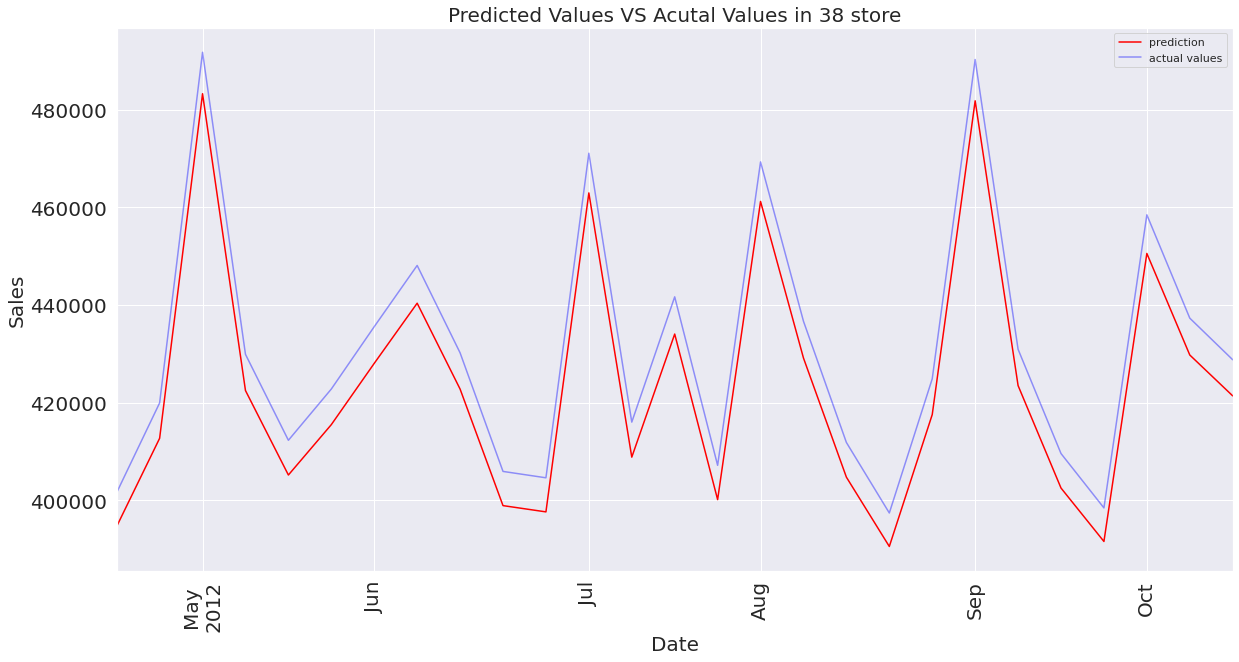

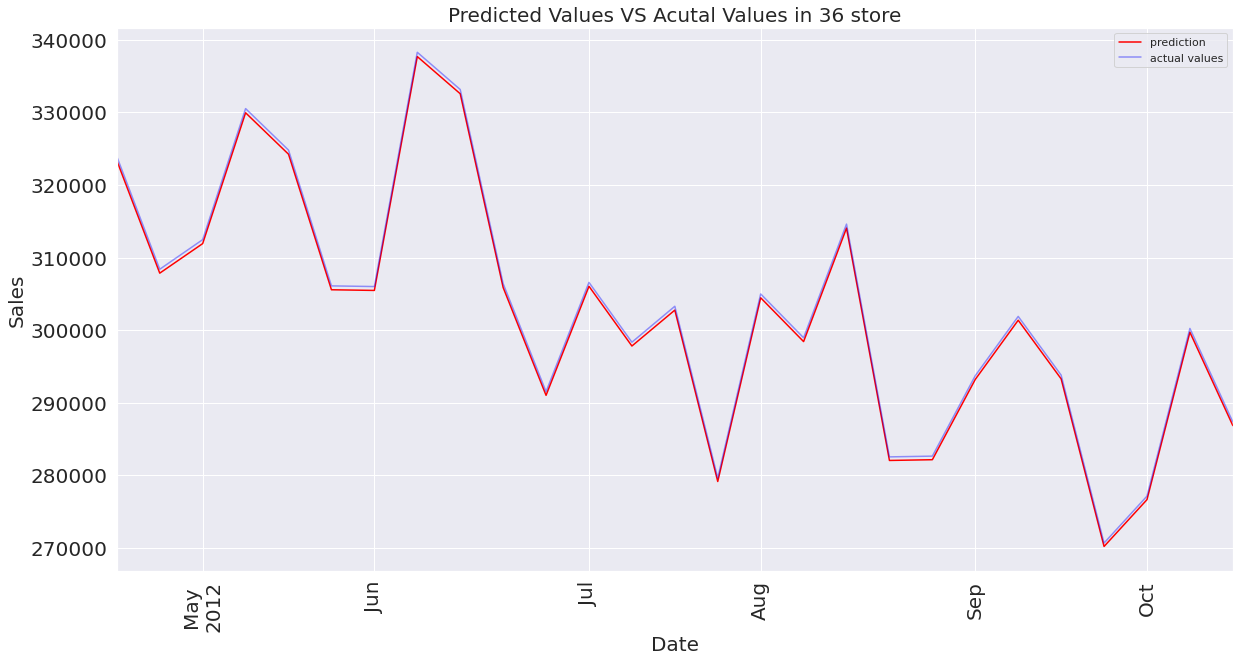

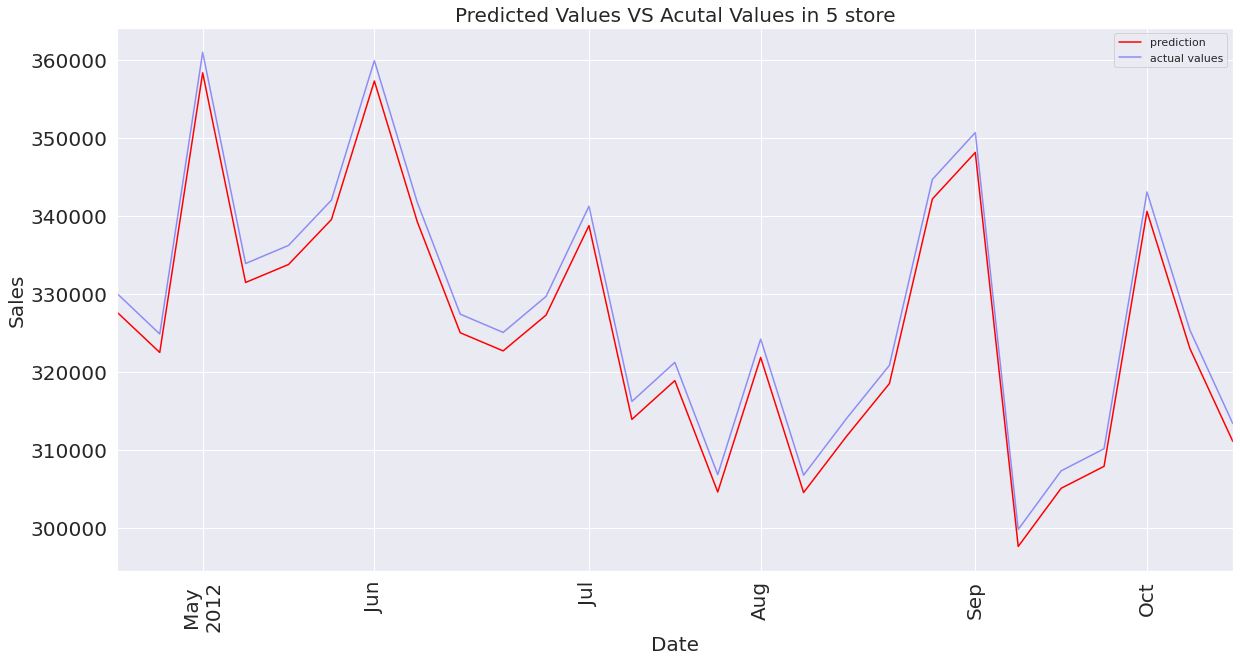

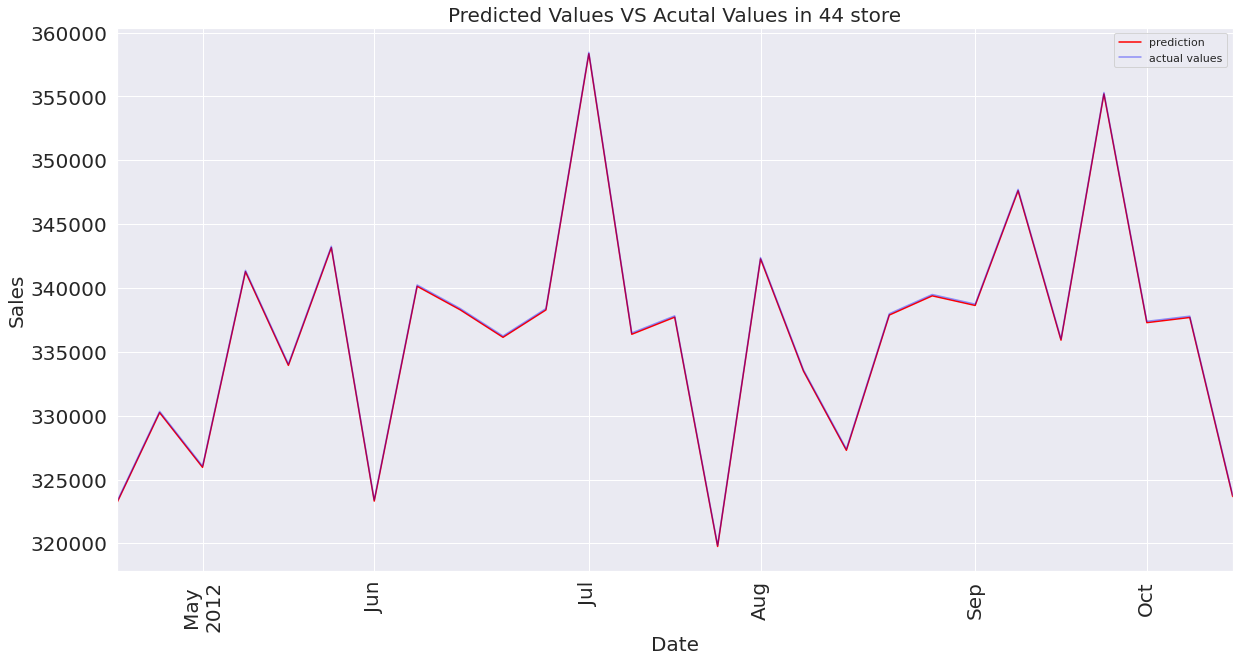

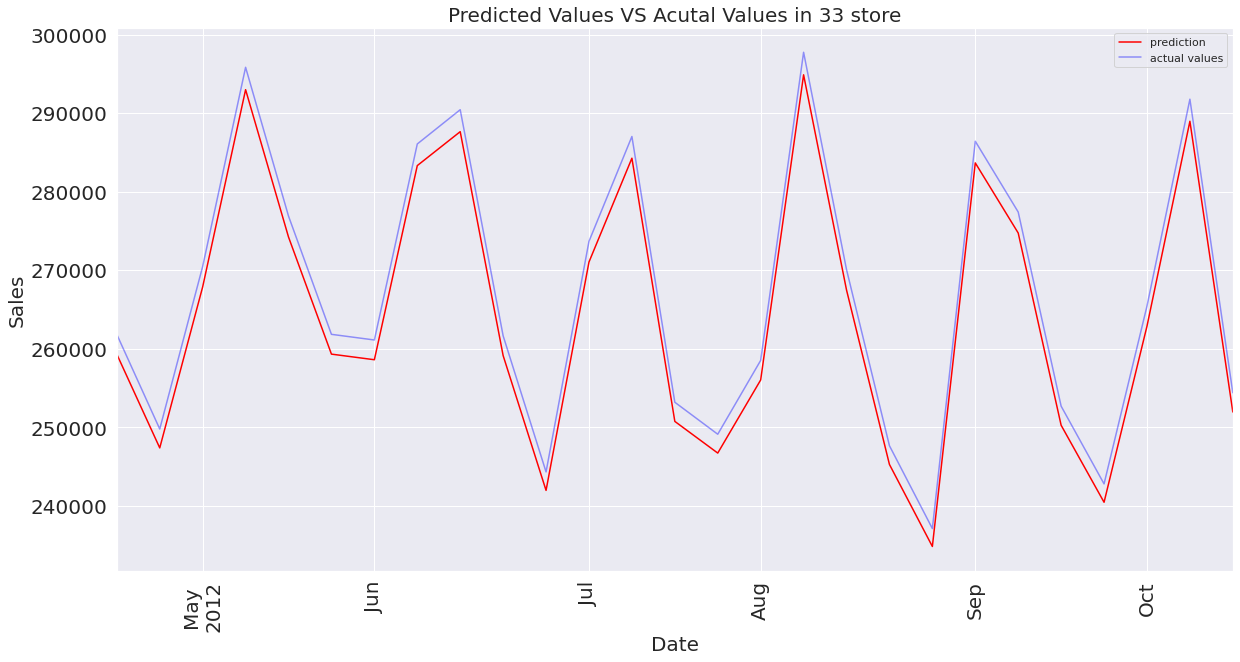

In [ ]:
for store_id in EachStore:
    # Obtain one store's data
    store = data[data.Store == store_id]

    # Train/test split, normalization, reshape
    x_train, x_test, y_train, y_test = normalization_train_test_split(store)

    # Define model
    model = Sequential()
    model.add(LSTM(60, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

    # Fit network
    history = model.fit(x_train, y_train, epochs=100, batch_size=15, verbose=0, shuffle=False)

    # Make predictions
    y_test_pre = model.predict(x_test)
    rmse_val = RMSE(y_test[:-1], [i[0] for i in y_test_pre][1:])
    print(f"{store_id} - RMSE: {rmse_val:.3f}")

    # Create DataFrame for plotting
    pa = pd.DataFrame()
    pa['Date'] = list(store.Date.iloc[int(len(store)*0.8):])[1:-1]
    pa['Prediction'] = [i[0] for i in y_test_pre][1:]
    pa['Actual Values'] = list(y_test[:-1])

    # Plot predictions vs actual
    plt.figure(figsize=(20,10))
    pa.groupby('Date')['Prediction'].sum().plot(label='Prediction', color='red', alpha=1)
    pa.groupby('Date')['Actual Values'].sum().plot(label='Actual Values', color='blue', alpha=0.4)
    plt.xticks(rotation=90, fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel('Sales', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.title(f"Predicted vs Actual Sales in Store {store_id}", fontsize=20)
    plt.legend()
    plt.show()

###Store-Level Split

This block partitions stores into **Training**, **Validation**, and **Testing** groups.  
Instead of splitting by rows or dates, we assign entire stores to one of three groups using reproducible random values.  


In [ ]:
# Count records by store and date (exploratory)
store_counts = data.groupby('Store').size()
date_counts = data.groupby('Date').size()
print("Stores:", store_counts.shape[0], "Dates:", date_counts.shape[0])
# Output: ""Stores: (45, 7) Dates: (143, 7)

# Extract unique store IDs
pd_id = data[['Store']].drop_duplicates().reset_index(drop=True)
# (45, 1)

# Generate reproducible random values for each store
np.random.seed(42)
pd_id['rand_val'] = np.random.rand(pd_id.shape[0])

# Assign modeling groups based on random thresholds
pd_id['MODELING_GROUP'] = np.where(
    pd_id['rand_val'] <= 0.35, 'TRAINING',
    np.where(pd_id['rand_val'] <= 0.65, 'VALIDATION', 'TESTING')
)

# Check distribution of groups
group_counts = pd_id.groupby('MODELING_GROUP')['Store'].count()
print("Group distribution:\n", group_counts)
#MODELING_GROUP
#TESTING       13
#TRAINING      17
#VALIDATION    15
#Name: wookie, dtype: int64

# Merge back with main data
data = data.merge(pd_id, on='Store', how='inner').sort_values(['Store','Date'])
data.head()

Store       Date  Weekly_Sales  ...  IsHolidayNumeric  wookie  MODELING_GROUP
0         1 2010-02-05    1643690.90  ...                 0  0.7270         TESTING
1         1 2011-11-11    1594938.89  ...                 0  0.7270         TESTING
2         1 2011-11-18    1539483.70  ...                 0  0.7270         TESTING
3         1 2011-11-25    2033320.66  ...                 1  0.7270         TESTING
4         1 2011-12-02    1584083.95  ...                 0  0.7270         TESTING
...     ...        ...           ...  ...               ...     ...             ...
6430     45 2011-01-07     680254.35  ...                 0  0.2612        TRAINING
6431     45 2011-01-14     654018.95  ...                 0  0.2612        TRAINING
6432     45 2011-01-21     644285.33  ...                 0  0.2612        TRAINING
6433     45 2011-06-10     814395.17  ...                 0  0.2612        TRAINING
6434     45 2012-10-26     760281.43  ...                 0  0.2612        TRAINING

[6435 rows x 10 columns]

In [ ]:
# Inspect one store's assignment
data.loc[(data['Store']==1) & (data['MODELING_GROUP']=='TESTING')]

Store       Date  Weekly_Sales  ...  IsHolidayNumeric  wookie  MODELING_GROUP
0        1 2010-02-05    1643690.90  ...                 0   0.727         TESTING
1        1 2011-11-11    1594938.89  ...                 0   0.727         TESTING
2        1 2011-11-18    1539483.70  ...                 0   0.727         TESTING
3        1 2011-11-25    2033320.66  ...                 1   0.727         TESTING
4        1 2011-12-02    1584083.95  ...                 0   0.727         TESTING
..     ...        ...           ...  ...               ...     ...             ...
138      1 2010-12-31    1367320.01  ...                 1   0.727         TESTING
139      1 2011-01-07    1444732.28  ...                 0   0.727         TESTING
140      1 2011-01-14    1391013.96  ...                 0   0.727         TESTING
141      1 2011-01-21    1327405.42  ...                 0   0.727         TESTING
142      1 2010-12-10    1682614.26  ...                 0   0.727         TESTING

[143 rows x 10 columns]

## Conclusion

- **ARIMA** demonstrates classical time series forecasting for linear dynamics.  
- **LSTM** highlights the power of neural networks in capturing sequential dependencies.  
- **Panel data models** (pooled, fixed, random effects) provide econometric tools for multi‑entity datasets, supported by diagnostic tests.  
- **Airline example** illustrates estimator comparison in a compact dataset.  
- **RNN models** extend forecasting to panel data with per‑store evaluation.  
- **Store‑level splits** ensure robust training, validation, and testing across distinct entities.  

This notebook serves as a comprehensive practice archive, combining econometric and machine learning approaches to time series and panel data analysis.